In [2]:
import os
import sys
import shutil

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink
import seaborn as sns

import statsmodels.api as sm

import matplotlib.patches as patches
import matplotlib

from basic_tools import *

"""

jupyter nbconvert 5_association.ipynb --to script
python 5_association.py albumin 2 0

"""

'\n\njupyter nbconvert 5_association.ipynb --to script\npython 5_association.py albumin 2 0\n\n'

In [3]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [4]:
phenotype_info=pd.read_csv('data/phenotype_pubname.tsv',sep='\t',index_col=0)

In [5]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')
phenotypes=phenotypes.set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]

binary_continuous_traits=phenotypes.columns.difference(['age','sex','cohort','diabetes'])
print(len(binary_continuous_traits))

97


In [6]:
binary_continuous_traits_filtered=[]
for phenotype_name in binary_continuous_traits:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
    
    num_data=(pheno['pheno']!=-9).sum()
    if num_data<10000:
        print(phenotype_name,num_data,'excluded')
    else:
        binary_continuous_traits_filtered.append(phenotype_name)
        
print(len(binary_continuous_traits_filtered))        
binary_continuous_traits=binary_continuous_traits_filtered

FEV_over_FVC_predicted 7440 excluded
FEV_predicted 7440 excluded
FVC_predicted 7441 excluded
MVV_predicted 7441 excluded
bone_density_distal_sos 7242 excluded
bone_density_midshaft_sos 7261 excluded
child_dead 3934 excluded
child_present 3843 excluded
freet4 284 excluded
insomnia 5148 excluded
peripheral_vascular_diseases 4509 excluded
renin 7500 excluded
rheumatoid_arthritis 4876 excluded
sleep_duration 7480 excluded
tsh 286 excluded
82


In [42]:
gene_bed_path='data/mart_export_grch37.txt'
gene_bed=pd.read_csv(gene_bed_path,sep='\t')
gene_bed=gene_bed.drop(columns='Exon stable ID')
gene_bed=gene_bed[(gene_bed['Gene start (bp)']>=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min())&(gene_bed['Gene end (bp)']<=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]
gene_bed=gene_bed[(gene_bed['Transcript type']=='protein_coding')]
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name','Gene start (bp)','Gene end (bp)'])]
print(gene_bed.shape)
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name'])]
print(gene_bed.shape)

gene_assign=plink_KCHIP_HLA_AA_SNP_1000G_bim[['pos']]

for idx,row in gene_bed.iterrows():
    gene_assign[row['Gene name']]=0
    
for idx,row in gene_bed.iterrows():    
    gene_assign[row['Gene name']][(gene_assign['pos']>=row['Gene start (bp)'])&(gene_assign['pos']<=row['Gene end (bp)'])]=1

#gene_assign.columns=gene_assign.columns.str.replace('HLA-','HLA_')        
    
HLA_names=np.unique([i[0].split('_')[1] for i in plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index.str.split('*')])

for HLA_name in HLA_names:
    gene_select=gene_assign[gene_assign.index.str.contains('HLA_'+HLA_name)|gene_assign.index.str.contains('SNPS_'+HLA_name)|gene_assign.index.str.contains('AA_'+HLA_name)]#print(gene_select.sort_values('pos').iloc[0],gene_select.sort_values('pos').iloc[-1])
    HLA_name='HLA-{}'.format(HLA_name)
    gene_assign[HLA_name][(gene_assign['pos']>=gene_select['pos'].min())&(gene_assign['pos']<=gene_select['pos'].max())]=1 

(209, 30)
(207, 30)


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
gene_assign

,pos,ZNF165,ZSCAN16,ZKSCAN8,ZSCAN9,ZKSCAN4,NKAPL,PGBD1,ZSCAN31,ZKSCAN3,...,C6orf1,NUDT3,RPS10-NUDT3,RPS10,PACSIN1,SPDEF,C6orf106,SNRPC,UHRF1BP1,TAF11
snp,,,,,,,,,,,,,,,,,,,,,
6:28000361_T/C,28000361,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6:28000610_C/A,28000610,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6:28001003_A/C,28001003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6:28001033_T/C,28001033,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6:28001610_T/C,28001610,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6:34997188_C/T,34997188,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6:34997259_G/A,34997259,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6:34997606_T/A,34997606,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [233]:
gene_bed[gene_bed['Gene name'].str.contains('HLA')]

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Transcript start (bp),Transcript end (bp),Protein stable ID,Protein stable ID version,...,Transcript type,Gene type,Gene % GC content,Transcript count,Source of transcript name,Transcript name,Source of gene name,Gene name,GENCODE basic annotation,Transcript length (including UTRs and CDS)
2188,ENSG00000204642,ENSG00000204642.9,ENST00000376861,ENST00000376861.1,29690552,29706305,29690552,29694303,ENSP00000366057,ENSP00000366057.1,...,protein_coding,protein_coding,45.02,17,HGNC transcript name,HLA-F-001,HGNC Symbol,HLA-F,1.0,1544
2317,ENSG00000204632,ENSG00000204632.7,ENST00000376828,ENST00000376828.2,29794744,29798902,29794744,29798902,ENSP00000366024,ENSP00000366024.2,...,protein_coding,protein_coding,56.38,7,HGNC transcript name,HLA-G-002,HGNC Symbol,HLA-G,1.0,1490
2393,ENSG00000206503,ENSG00000206503.7,ENST00000396634,ENST00000396634.1,29909037,29913661,29909037,29913661,ENSP00000379873,ENSP00000379873.1,...,protein_coding,protein_coding,55.18,8,HGNC transcript name,HLA-A-001,HGNC Symbol,HLA-A,1.0,1868
2953,ENSG00000204592,ENSG00000204592.5,ENST00000376630,ENST00000376630.4,30457244,30461982,30457244,30461982,ENSP00000365817,ENSP00000365817.4,...,protein_coding,protein_coding,55.48,3,HGNC transcript name,HLA-E-001,HGNC Symbol,HLA-E,1.0,2601
4716,ENSG00000204525,ENSG00000204525.10,ENST00000376228,ENST00000376228.5,31236526,31239907,31236526,31239863,ENSP00000365402,ENSP00000365402.5,...,protein_coding,protein_coding,59.28,9,HGNC transcript name,HLA-C-001,HGNC Symbol,HLA-C,1.0,1536
4764,ENSG00000234745,ENSG00000234745.5,ENST00000412585,ENST00000412585.2,31321649,31324965,31321649,31324964,ENSP00000399168,ENSP00000399168.2,...,protein_coding,protein_coding,59.00,7,HGNC transcript name,HLA-B-001,HGNC Symbol,HLA-B,1.0,1547
9245,ENSG00000204287,ENSG00000204287.9,ENST00000395388,ENST00000395388.2,32407619,32412823,32407619,32412823,ENSP00000378786,ENSP00000378786.2,...,protein_coding,protein_coding,42.88,2,HGNC transcript name,HLA-DRA-001,HGNC Symbol,HLA-DRA,1.0,1280
9257,ENSG00000198502,ENSG00000198502.5,ENST00000374975,ENST00000374975.3,32485120,32498064,32485120,32498064,ENSP00000364114,ENSP00000364114.3,...,protein_coding,protein_coding,42.84,1,HGNC transcript name,HLA-DRB5-001,HGNC Symbol,HLA-DRB5,1.0,1260
9284,ENSG00000196126,ENSG00000196126.6,ENST00000360004,ENST00000360004.5,32546546,32557625,32546546,32557625,ENSP00000353099,ENSP00000353099.5,...,protein_coding,protein_coding,44.36,1,HGNC transcript name,HLA-DRB1-001,HGNC Symbol,HLA-DRB1,1.0,1229
9290,ENSG00000196735,ENSG00000196735.7,ENST00000422863,ENST00000422863.1,32595956,32614839,32595956,32605308,ENSP00000405797,ENSP00000405797.1,...,protein_coding,protein_coding,40.06,7,HGNC transcript name,HLA-DQA1-010,HGNC Symbol,HLA-DQA1,NaN,520


In [242]:
np.min(np.array([31321649,31324965])-31298340)

23309

In [244]:
np.min(np.array([29941260,29945884])-29928903)

12357

In [259]:
np.min(np.array([int(i) for i in '31,353,872-31,357,188'.replace(',','').split('-')])-\
31298340)/1000

55.532

In [261]:
np.min(np.array([int(i) for i in '29,941,260-29,945,884'.replace(',','').split('-')])-\
29928903)/1000

12.357

In [262]:
np.min(np.array([int(i) for i in '32,659,467-32,668,383'.replace(',','').split('-')])-\
32672009)/1000

-12.542

In [263]:
np.min(np.array([int(i) for i in '34,236,873-34,246,231'.replace(',','').split('-')])-\
34217972)/1000

18.901

In [264]:
np.min(np.array([int(i) for i in '34,236,873-34,246,231'.replace(',','').split('-')])-\
34279270)/1000

-42.397

In [265]:
np.min(np.array([int(i) for i in '32,628,179-32,647,062'.replace(',','').split('-')])-\
32658715)/1000

-30.536

In [266]:
np.min(np.array([int(i) for i in '34,877,462-34,888,071'.replace(',','').split('-')])-\
34999572)/1000

-122.11

In [267]:
np.min(np.array([int(i) for i in '31,353,872-31,357,188'.replace(',','').split('-')])-\
31347633)/1000

6.239

In [268]:
np.min(np.array([int(i) for i in '31,353,872-31,357,188'.replace(',','').split('-')])-\
31273984)/1000


79.888

In [269]:
np.min(np.array([int(i) for i in '30,489,509-30,494,194'.replace(',','').split('-')])-\
30769814)/1000

-280.305

In [270]:
np.min(np.array([int(i) for i in '31,399,784-31,415,315'.replace(',','').split('-')])-\
31403620)/1000

-3.836

In [271]:
np.min(np.array([int(i) for i in '31,399,784-31,415,315'.replace(',','').split('-')])-\
31383753)/1000

16.031

In [272]:
np.min(np.array([int(i) for i in '34,236,873-34,246,231'.replace(',','').split('-')])-\
34210987)/1000

25.886

In [273]:
np.min(np.array([int(i) for i in '32,578,769-32,589,848'.replace(',','').split('-')])-\
32234853)/1000

343.916

In [274]:
np.min(np.array([int(i) for i in '33,075,990-33,089,696'.replace(',','').split('-')])-\
33108491)/1000

-32.501

In [275]:
np.min(np.array([int(i) for i in '32,628,179-32,647,062'.replace(',','').split('-')])-\
32485507)/1000

142.672

In [284]:
np.min(np.array([int(i) for i in '31,268,749-31,272,130'.replace(',','').split('-')])-\
31194743)/1000

74.006

In [285]:
np.min(np.array([int(i) for i in '31,494,881-31,511,124'.replace(',','').split('-')])-\
31570720)/1000

-75.839

In [286]:
np.min(np.array([int(i) for i in '32,209,049-32,287,940'.replace(',','').split('-')])-\
32324081)/1000

-115.032

# conversion manual

In [22]:
phenotype_info

,phenotype_name_publication,phenotype_category,phenotype_type
phenotype_name,,,
bladder_cancer,Bladder cancer,Cancer,binary
breast_cancer,Breast cancer,Cancer,binary
cervical_cancer,Cervical cancer,Cancer,binary
colorectal_cancer,Colorectal cancer,Cancer,binary
liver_cancer,Liver cancer,Cancer,binary
...,...,...,...
protein_in_blood,Protein in blood,Protein QTL,continuous
total_bilirubin,Total bilirubin,Protein QTL,continuous
renin,Renin,Protein QTL,continuous


In [64]:
conversion_manual=pd.read_csv(conversion_manual_path,sep='\t')
conversion_manual=conversion_manual[~conversion_manual['phenotype_code'].isnull()]
conversion_manual.head()

,phenotype_code,commands
0,NC1_AGE,age@(x!=66666)&(x!=77777)&(x!=99999)@x
1,CT1_AGE,age@(x!=66666)&(x!=77777)&(x!=99999)@x
2,AS1_AGE,age@(x!=66666)&(x!=77777)&(x!=99999)@x
4,NC1_SEX,sex@1@1|sex@2@2
5,CT1_SEX,sex@1@1|sex@2@2


In [279]:
conversion_manual_pub=conversion_manual.copy()

conversion_manual_pub['phenotype_name']=[i[0] for i in conversion_manual_pub['commands'].str.split('@')]

conversion_manual_pub=conversion_manual_pub[conversion_manual_pub['phenotype_name'].apply(lambda x: x in binary_continuous_traits)]

In [280]:
conversion_manual_pub['phenotype_type']=phenotype_info.loc[conversion_manual_pub['phenotype_name']]['phenotype_type'].values
conversion_manual_pub['phenotype_category']=phenotype_info.loc[conversion_manual_pub['phenotype_name']]['phenotype_category'].values
conversion_manual_pub['phenotype_name_publication']=phenotype_info.loc[conversion_manual_pub['phenotype_name']]['phenotype_name_publication'].values

for idx,row in phenotype_info.iterrows():
    conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace(idx+'@'+'(x!=66666)&(x!=77777)&(x!=99999)@x','-',regex=False)    
    conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace(idx+'@'+'+','contains ',regex=False)
    conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace(idx+'@','')
    #conversion_manual_pub['phenotype_name_publication']=conversion_manual_pub['phenotype_name_publication'].str.replace(idx,row['phenotype_name_publication'])
    #conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace(row['phenotype_name_publication']+'@',''+row['phenotype_name_publication']+'  <-    if ')
    
for idx,row in phenotype_info.iterrows():    
    conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace('x','value',regex=False)
    conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace('@2',' -> case',regex=False)
    conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace('-/10','divide by 10 for unit conversion',regex=False)
    
    
    #conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace('|',' , ')
    #conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace('&',' and ')

In [281]:
conversion_manual_pub

,phenotype_code,commands,phenotype_name,phenotype_type,phenotype_category,phenotype_name_publication
8,NC1_ASTH,2 -> case,asthma,binary,Immune-related disease,Asthma
9,CT1_ASTH,2 -> case,asthma,binary,Immune-related disease,Asthma
10,AS1_PDAS,2 -> case,asthma,binary,Immune-related disease,Asthma
11,AS1_TRTAS,2 -> case,asthma,binary,Immune-related disease,Asthma
13,NC1_BRON,2 -> case,chronic_bronchitis,binary,Other disease,Chronic bronchitis
...,...,...,...,...,...,...
392,CT1_PER,2 -> case,periodontal_disease,binary,Other disease,Periodontal disease
397,NC1_NOI,2 -> case,neurosis,binary,Nervous system disease,Neurosis
399,CT1_GF1,-,grip_strength,continuous,Anthropometric QTL,Grip strength
409,NC1_TOTPRT,-,protein_in_blood,continuous,Protein QTL,Protein in blood


In [283]:
conversion_manual_pub\
.sort_values(['phenotype_type','phenotype_category'])\
[['phenotype_code','commands','phenotype_category','phenotype_name_publication']]\
.rename(columns={'phenotype_code':'KoGES code',
                 'commands':'Mapping',
                 'phenotype_category':'Category',
                 'phenotype_name_publication':'Phenotype name'
               }).to_csv(data_out_pub_path+'KoGES_phenotype.tsv',sep='\t',encoding='utf-8-sig',index=None)

In [57]:
conversion_manual_pub

,phenotype_code,commands,phenotype_name,phenotype_type,phenotype_category,phenotype_name_publication
8,NC1_ASTH,2 : case,asthma,binary,Immune-related disease,Asthma
9,CT1_ASTH,2 : case,asthma,binary,Immune-related disease,Asthma
10,AS1_PDAS,2 : case,asthma,binary,Immune-related disease,Asthma
11,AS1_TRTAS,2 : case,asthma,binary,Immune-related disease,Asthma
13,NC1_BRON,2 : case,chronic_bronchitis,binary,Other disease,Chronic bronchitis
...,...,...,...,...,...,...
392,CT1_PER,2 : case,periodontal_disease,binary,Other disease,Periodontal disease
397,NC1_NOI,2 : case,neurosis,binary,Nervous system disease,Neurosis
399,CT1_GF1,-,grip_strength,continuous,Anthropometric QTL,Grip strength
409,NC1_TOTPRT,-,protein_in_blood,continuous,Protein QTL,Protein in blood


In [70]:
len(conversion_manual_pub['phenotype_name_publication'].unique())

81

In [71]:
len(binary_continuous_traits)

82

In [72]:
set(binary_continuous_traits).difference(conversion_manual_pub['phenotype_name'].unique())

{'bmi'}

In [357]:
conversion_manual_pub[conversion_manual_pub['phenotype_category']=='Other QTL']

,phenotype_code,commands,phenotype_name,phenotype_type,phenotype_category,phenotype_name_publication
186,NC1_PWI,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pwi_total,continuous,Other QTL,Personal Well-being Index
187,CT1_PWI,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pwi_total,continuous,Other QTL,Personal Well-being Index
232,NC1_PULSE1,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pulse,continuous,Other QTL,Pulse rate
233,CT1_PULSE,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pulse,continuous,Other QTL,Pulse rate
234,AS1_PLLIE1,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pulse,continuous,Other QTL,Pulse rate
239,NC1_MNSAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menarche_onset_age,continuous,Other QTL,Menarche onset age
240,CT1_MNSAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menarche_onset_age,continuous,Other QTL,Menarche onset age
241,AS1_MNSAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menarche_onset_age,continuous,Other QTL,Menarche onset age
243,NC1_PMAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menopause_age,continuous,Other QTL,Menopause age
244,CT1_PMAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menopause_age,continuous,Other QTL,Menopause age


In [368]:
len(phenotype_info),\
len(phenotype_info.loc[binary_continuous_traits]),\
len(phenotype_info.loc[binary_continuous_traits][phenotype_info.loc[binary_continuous_traits]['phenotype_type']=='binary']),\
len(phenotype_info.loc[binary_continuous_traits][phenotype_info.loc[binary_continuous_traits]['phenotype_type']=='continuous']),\

(98, 82, 47, 35)

In [366]:
phenotype_info.loc[binary_continuous_traits]['phenotype_type']

phenotype_name
acute_liver_disease                          binary
albumin                                  continuous
allergic_disease                             binary
alt                                      continuous
angina_pectoris_myocardial_infarction        binary
arthritis                                    binary
ast                                      continuous
asthma                                       binary
benign_prostatic_hyperplasia                 binary
big_baby                                     binary
bladder_cancer                               binary
blood_in_urine                               binary
bmi                                      continuous
breast_cancer                                binary
bun                                      continuous
cataract                                     binary
cervical_cancer                              binary
child_delivery_number                    continuous
cholelithiasis_cholecystitis                 bina

# marker information

In [46]:
plink_KCHIP_HLA_AA_SNP_1000G_fam.shape

(125673, 6)

## KCHIP original

In [75]:
plink_KCHIP_original=PyPlink('data/genotype/1_KCHIP_unimputed/KCHIP_original/KCHIP_HLA')
plink_KCHIP_original_fam=plink_KCHIP_original.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_original_bim=plink_KCHIP_original.get_bim()

In [114]:
plink_KCHIP_original_bim.shape,plink_KCHIP_original_bim[~plink_KCHIP_original_bim.duplicated('pos')].shape

((5292, 5), (5291, 5))

In [216]:
plink_KCHIP_original_bim

,chrom,pos,cm,a1,a2
snp,,,,,
AX-11643368,6,29002062,0,G,A
AX-41942515,6,29004091,0,T,C
AX-11688629,6,29006250,0,T,C
AX-11642535,6,29006844,0,G,A
AX-15351471,6,29007847,0,G,C
...,...,...,...,...,...
AX-35759153,6,33975366,0,A,G
AX-41962569,6,33988441,0,C,T
AX-35759287,6,33992059,0,G,A


## KCHIP imputed

In [8]:
#plink_KCHIP_original=PyPlink('data/genotype/0_1000G/KCHIP_HLA_6_28Mb_35Mb_20200113_QC.recode.newQC.nooverlap')
plink_KCHIP_HLA_AA_SNP=PyPlink('data/genotype/3_KCHIP_bmarkerphased/KCHIP_HLA_hg19.bMarker.QC')
plink_KCHIP_HLA_AA_SNP_fam=plink_KCHIP_HLA_AA_SNP.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_bim=plink_KCHIP_HLA_AA_SNP.get_bim()

In [9]:
marker_all=plink_KCHIP_HLA_AA_SNP_bim[:].copy()
marker_HLA=plink_KCHIP_HLA_AA_SNP_bim[plink_KCHIP_HLA_AA_SNP_bim.index.str.contains('HLA_')].copy()
marker_AA=plink_KCHIP_HLA_AA_SNP_bim[plink_KCHIP_HLA_AA_SNP_bim.index.str.contains('AA_')].copy()
marker_SNP=marker_all.loc[marker_all.index.difference(marker_HLA.index).difference(marker_AA.index)]

In [10]:
marker_all.shape[0]-5292

9097

In [11]:
marker_HLA.shape,marker_HLA[~marker_HLA.duplicated('pos')].shape

((119, 5), (8, 5))

In [12]:
marker_AA.shape,marker_AA[~marker_AA.duplicated('pos')].shape

((574, 5), (349, 5))

In [13]:
marker_SNP.shape,marker_SNP[~marker_SNP.duplicated('pos')].shape

((13696, 5), (11308, 5))

In [14]:
marker_SNP_SNP=marker_SNP[marker_SNP.index.str.startswith('SNP')]
marker_SNP_SNP.shape,marker_SNP_SNP[~marker_SNP_SNP.duplicated('pos')].shape

((8276, 5), (5969, 5))

In [15]:
marker_SNP_INS=marker_SNP[marker_SNP.index.str.startswith('INS_SNP')]
marker_SNP_INS.shape,marker_SNP_INS[~marker_SNP_INS.duplicated('pos')].shape

((130, 5), (130, 5))

In [16]:
119+574+13696-5292

9097

In [17]:
marker_all.loc[marker_all.index.difference(plink_KCHIP_original_bim.index)]

NameError: name 'plink_KCHIP_original_bim' is not defined

In [18]:
119+349+11308

11776

In [111]:
11308-5969-130

5209

HLA omnibus 따로

AA omnibus or single


In [108]:
119+349+11308

11776

In [88]:
marker_SNP[marker_SNP['a1']=='z']

,chrom,pos,cm,a1,a2
snp,,,,,
INS_SNPS_A_1255x1256_29911586,6,29911586,0,z,Z
INS_SNPS_A_1406x1407_29911736,6,29911736,0,z,Z
INS_SNPS_B_1159x1160_31323776,6,31323776,0,z,Z
INS_SNPS_B_1890x1891_31323046,6,31323046,0,z,Z
INS_SNPS_B_84x85_31324852,6,31324852,0,z,Z
INS_SNPS_DPA1_1758x1759_33039590,6,33039590,0,z,Z
INS_SNPS_DQA1_1367x1368_32606602,6,32606602,0,z,Z
INS_SNPS_DQB1_1115x1116_32633270,6,32633270,0,z,Z
INS_SNPS_DQB1_1517x1518_32632868,6,32632868,0,z,Z


In [79]:
marker_SNP

,chrom,pos,cm,a1,a2
snp,,,,,
AFFX-SP-000047,6,31059900,0,C,T
AX-100009832,6,32713044,0,T,C
AX-106712726,6,31504546,0,A,C
AX-106712747,6,31274555,0,T,C
AX-106713356,6,30716719,0,T,C
...,...,...,...,...,...
SNPS_DRB1_9998_32547522_intron5_T,6,32547522,0,p,a
SNPS_DRB1_9998_32547522_intron5_x,6,32547522,0,p,a
SNPS_DRB1_9999_32547521_intron5_.,6,32547521,0,p,a


## 1000G

In [210]:
#plink_KCHIP_original=PyPlink('data/genotype/0_1000G/KCHIP_HLA_6_28Mb_35Mb_20200113_QC.recode.newQC.nooverlap')
plink_KCHIP_1000G=PyPlink('data/genotype/4_merge/1000G')
plink_KCHIP_1000G_fam=plink_KCHIP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_1000G_bim=plink_KCHIP_1000G.get_bim()

In [304]:
plink_KCHIP_1000G_bim[plink_KCHIP_1000G_bim.index.str.contains('AX')]

,chrom,pos,cm,a1,a2
snp,,,,,


In [211]:
marker_all=plink_KCHIP_1000G_bim[:].copy()

In [212]:
marker_all.shape

(56598, 5)

In [213]:
marker_all[~((marker_all['a1'].str.len()==1)&(marker_all['a2'].str.len()==1))].shape

(5357, 5)

In [214]:
marker_all[((marker_all['a1'].str.len()==1)&(marker_all['a2'].str.len()==1))].shape

(51241, 5)

In [215]:
marker_all[~marker_all['a1'].map(lambda x: x in ['A','T','C','G']) & marker_all['a2'].map(lambda x: x in ['A','T','C','G'])]

,chrom,pos,cm,a1,a2
snp,,,,,
6:28008311_G/GTAA,6,28008311,0,GTAA,G
6:28012085_A/AGGAG,6,28012085,0,AGGAG,A
6:28016416_T/TTTAG,6,28016416,0,TTTAG,T
6:28017103_A/AAAAC,6,28017103,0,AAAAC,A
6:28021853_A/AG,6,28021853,0,AG,A
...,...,...,...,...,...
6:34983275_C/CA,6,34983275,0,CA,C
6:34984712_CTT/C,6,34984712,0,CTT,C
6:34989761_T/TA,6,34989761,0,TA,T


## all

In [19]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [20]:
marker_all=plink_KCHIP_HLA_AA_SNP_1000G_bim[:].copy()
marker_HLA=plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].copy()
marker_AA=plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('AA_')].copy()
marker_SNP=marker_all.loc[marker_all.index.difference(marker_HLA.index).difference(marker_AA.index)]

In [26]:
marker_HLA

,chrom,pos,cm,a1,a2
snp,,,,,
HLA_A*01:01,6,29910247,0,p,a
HLA_A*02:01,6,29910247,0,p,a
HLA_A*02:06,6,29910247,0,p,a
HLA_A*02:07,6,29910247,0,p,a
HLA_A*03:01,6,29910247,0,p,a
HLA_A*11:01,6,29910247,0,p,a
HLA_A*24:02,6,29910247,0,p,a
HLA_A*26:01,6,29910247,0,p,a
HLA_A*26:02,6,29910247,0,p,a


In [21]:
marker_all.shape

(70987, 5)

In [22]:
marker_HLA.shape

(119, 5)

In [23]:
marker_AA.shape

(574, 5)

In [24]:
marker_SNP.shape

(70294, 5)

In [25]:
119+574+70294

70987

In [342]:
5292+9097+56598

70987

In [352]:
marker_SNP

,chrom,pos,cm,a1,a2
snp,,,,,
6:28000361_T/C,6,28000361,0,C,T
6:28000610_C/A,6,28000610,0,A,C
6:28001003_A/C,6,28001003,0,C,A
6:28001033_T/C,6,28001033,0,C,T
6:28001610_T/C,6,28001610,0,C,T
...,...,...,...,...,...
SNPS_DRB1_9998_32547522_intron5_T,6,32547522,0,p,a
SNPS_DRB1_9998_32547522_intron5_x,6,32547522,0,p,a
SNPS_DRB1_9999_32547521_intron5_.,6,32547521,0,p,a


In [361]:
marker_all.loc[marker_all.index.difference(marker_HLA.index)].shape

(70868, 5)

In [360]:
marker_all.loc[marker_all.index.difference(marker_HLA.index).difference(marker_AA.index)].shape

(70294, 5)

In [358]:
marker_AA.shape

(574, 5)

In [364]:
70987-119-574

70294

In [344]:
marker_all.shape

(70987, 5)

In [345]:
marker_HLA.shape

(119, 5)

In [346]:
marker_AA.shape,marker_AA[~marker_AA.duplicated('pos')].shape

((574, 5), (349, 5))

In [347]:
marker_SNP[~marker_SNP['a1'].map(lambda x: x in ['A','T','C','G']) & marker_SNP['a2'].map(lambda x: x in ['A','T','C','G'])]

,chrom,pos,cm,a1,a2
snp,,,,,
6:28008311_G/GTAA,6,28008311,0,GTAA,G
6:28012085_A/AGGAG,6,28012085,0,AGGAG,A
6:28016416_T/TTTAG,6,28016416,0,TTTAG,T
6:28017103_A/AAAAC,6,28017103,0,AAAAC,A
6:28021853_A/AG,6,28021853,0,AG,A
...,...,...,...,...,...
SNPS_DRB1_9490_32548030_intron5,6,32548030,0,.,G
SNPS_DRB1_9491_32548029_intron5,6,32548029,0,.,G
SNPS_DRB1_9517_32548003_intron5,6,32548003,0,.,G


In [348]:
marker_SNP.shape,marker_SNP[~marker_SNP.duplicated('pos')].shape

((70294, 5), (67276, 5))

In [351]:
#marker_SNP[marker_SNP.duplicated('pos')]

In [217]:
5292+9099+56598

70989

In [61]:
119+349+13696

14164

In [62]:
56598+8276+130+5292

70296

In [63]:
67276

67276

In [64]:
#marker_all[marker_all['pos']>=33053550]

In [65]:
len(plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')]['pos'].unique()),\
len(plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('AA_')]['pos'].unique()),\
len(plink_KCHIP_HLA_AA_SNP_1000G_bim['pos'].unique())

(8, 349, 67448)

# MAF

In [27]:
def cal_maf(dosage_array):
    maf=(1*(dosage_array==1).sum()+2*(dosage_array==2).sum())/\
         (2*(dosage_array!=-1).sum())
    return maf

maf_list_list=[]
for idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].iterrows()):
    maf_list=[]
    assert row['a1']=='p'
    dosage=plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP)
    maf_list.append(cal_maf(dosage))
    for cohort in range(1,3+1):
        cohort_dosage=dosage[phenotypes['cohort']==cohort]
        #print('total: {:5d} -1:{:5d} 0:{:5d} 1:{:5d} 2:{:5d}'.format(len(cohort_dosage),(cohort_dosage==-1).sum(),(cohort_dosage==0).sum(),(cohort_dosage==1).sum(),(cohort_dosage==2).sum()))
        maf_list.append(cal_maf(cohort_dosage))
    
    maf_list_list.append(maf_list)

In [28]:
assert (phenotypes.index!=plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']).sum()==0

In [29]:
maf_df=pd.DataFrame(maf_list_list,index=plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index,columns=['all','AS','CT','NC'])

In [30]:
maf_df.index=maf_df.index.str.replace('_','-')

In [31]:
maf_df.head()

,all,AS,CT,NC
snp,,,,
HLA-A*01:01,0.017462,0.018733,0.017275,0.017930
HLA-A*02:01,0.164765,0.164454,0.163066,0.173798
HLA-A*02:06,0.086112,0.083081,0.086044,0.087692
HLA-A*02:07,0.034538,0.037465,0.034419,0.033982
HLA-A*03:01,0.015986,0.017878,0.015576,0.017375


In [32]:
maf_df.to_csv(data_out_pub_path+'HLA_allele_freq.tsv',sep='\t')

# GWAS each phenotype

In [1]:
len(binary_continuous_traits)

NameError: name 'binary_continuous_traits' is not defined

In [20]:
for phenotype_name in binary_continuous_traits:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    
    pheotype_name_publication=phenotype_info.loc[phenotype_name]['phenotype_name_publication'].replace(' ','_').replace('/','_')
    
    data_out_pub_phenotype_path=data_out_pub_path+pheotype_name_publication+'/'
    #print(data_out_pub_phenotype_path)
    shutil.rmtree(data_out_pub_phenotype_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data/out_pub/Acute_liver_disease/'

In [ ]:
for phenotype_name in binary_continuous_traits:
    phenotype_name='height'
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    
    pheotype_name_publication=phenotype_info.loc[phenotype_name]['phenotype_name_publication'].replace(' ','_').replace('/','_')
    
    data_out_pub_phenotype_path=data_out_pub_path+'phenotypes/'+pheotype_name_publication+'/'
    pathlib.Path(data_out_pub_phenotype_path).mkdir(parents=True, exist_ok=True)
    
    
    
    #pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
    #phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
    #phenotype_type    
    
    for step_idx_sub in range(1,100):
        print("phenotype_name: {}, phenotype_type:{} , Step : {} ".format(phenotype_name,'  ',step_idx_sub))
        #print(step_idx_sub)
        if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):
            print('meets end',step_idx_sub)
            break
            
        result_merge=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.merge.result.tsv'.format(step_idx_sub),sep='\t',index_col=0)
        result_merge=result_merge.drop(columns=['phenotype_name'])  
        result_merge['phenotype_name_publication']=phenotype_info.loc[phenotype_name]['phenotype_name_publication']
        #print(result_merge.columns)
        
        result_merge[['phenotype_name_publication','phenotype_type', 'samples(case/control)', 'step', 'condition',
               'marker_name', 'marker_name_pub', 'POS', 'A1', 'A2',
               'A1_freq_case', 'A1_freq_control', 'multi_allele', 'nobs', 'Z', 'coef',
               'std', 'chisq', 'df', 'P']].to_csv(data_out_pub_phenotype_path+'step_{:02d}.result.tsv'.format(step_idx_sub),sep='\t',index=None)        
        """
        result_merge[['phenotype_name_publication','phenotype_type', 'samples(case/control)', 'step', 'condition',
               'marker_name', 'marker_name_pub', 'note', 'term', 'POS', 'A1', 'A2',
               'A1_freq_case', 'A1_freq_control', 'multi_allele', 'nobs', 'Z', 'coef',
               'std', 'chisq', 'df', 'P']]
        """    
        
        shutil.copy(data_out_assoc_phenotype_path+'step_{:02d}.merge.manhattan.png'.format(step_idx_sub),
                    data_out_pub_phenotype_path+'step_{:02d}.manhattan.png'.format(step_idx_sub))         
        
        
        
    
        

phenotype_name: height, phenotype_type:   , Step : 1 
phenotype_name: height, phenotype_type:   , Step : 2 
phenotype_name: height, phenotype_type:   , Step : 3 
phenotype_name: height, phenotype_type:   , Step : 4 
phenotype_name: height, phenotype_type:   , Step : 5 


In [7]:
!tar -C data/out_pub/ -czvf data/out_pub/phenotypes.tar.gz phenotypes

phenotypes/
phenotypes/Personal_Well-being_Index/
phenotypes/Personal_Well-being_Index/step_01.result.tsv
phenotypes/Personal_Well-being_Index/step_01.manhattan.png
phenotypes/Delivered_low_birth_weight/
phenotypes/Delivered_low_birth_weight/step_01.result.tsv
phenotypes/Delivered_low_birth_weight/step_01.manhattan.png
phenotypes/Hyperlipidemia/
phenotypes/Hyperlipidemia/step_02.result.tsv
phenotypes/Hyperlipidemia/step_02.manhattan.png
phenotypes/Hyperlipidemia/step_01.result.tsv
phenotypes/Hyperlipidemia/step_01.manhattan.png
phenotypes/Menarche_onset_age/
phenotypes/Menarche_onset_age/step_01.result.tsv
phenotypes/Menarche_onset_age/step_01.manhattan.png
phenotypes/Mean_corpuscular_volume/
phenotypes/Mean_corpuscular_volume/step_02.result.tsv
phenotypes/Mean_corpuscular_volume/step_03.manhattan.png
phenotypes/Mean_corpuscular_volume/step_02.manhattan.png
phenotypes/Mean_corpuscular_volume/step_03.result.tsv
phenotypes/Mean_corpuscular_volume/step_01.result.tsv
phenotypes/Mean_corpus

phenotypes/Hematocrit/step_04.manhattan.png
phenotypes/Hematocrit/step_04.result.tsv
phenotypes/Hematocrit/step_03.result.tsv
phenotypes/Hematocrit/step_01.result.tsv
phenotypes/Hematocrit/step_01.manhattan.png
phenotypes/Hypertension/
phenotypes/Hypertension/step_02.result.tsv
phenotypes/Hypertension/step_02.manhattan.png
phenotypes/Hypertension/step_01.result.tsv
phenotypes/Hypertension/step_01.manhattan.png
phenotypes/Diastolic_blood_pressure/
phenotypes/Diastolic_blood_pressure/step_02.result.tsv
phenotypes/Diastolic_blood_pressure/step_02.manhattan.png
phenotypes/Diastolic_blood_pressure/.ipynb_checkpoints/
phenotypes/Diastolic_blood_pressure/.ipynb_checkpoints/step_01.manhattan-checkpoint.png
phenotypes/Diastolic_blood_pressure/.ipynb_checkpoints/step_02.manhattan-checkpoint.png
phenotypes/Diastolic_blood_pressure/step_01.result.tsv
phenotypes/Diastolic_blood_pressure/step_01.manhattan.png
phenotypes/Asthma/
phenotypes/Asthma/step_01.result.tsv
phenotypes/Asthma/step_01.manhattan

phenotypes/Platelet_count/step_03.manhattan.png
phenotypes/Platelet_count/step_06.result.tsv
phenotypes/Platelet_count/step_06.manhattan.png
phenotypes/Platelet_count/step_02.manhattan.png
phenotypes/Platelet_count/step_07.result.tsv
phenotypes/Platelet_count/step_08.manhattan.png
phenotypes/Platelet_count/step_04.manhattan.png
phenotypes/Platelet_count/step_08.result.tsv
phenotypes/Platelet_count/step_04.result.tsv
phenotypes/Platelet_count/step_07.manhattan.png
phenotypes/Platelet_count/step_03.result.tsv
phenotypes/Platelet_count/step_05.manhattan.png
phenotypes/Platelet_count/step_01.result.tsv
phenotypes/Platelet_count/step_05.result.tsv
phenotypes/Platelet_count/step_01.manhattan.png
phenotypes/Tuberculosis/
phenotypes/Tuberculosis/step_01.result.tsv
phenotypes/Tuberculosis/step_01.manhattan.png
phenotypes/Thyroid_disease/
phenotypes/Thyroid_disease/step_02.result.tsv
phenotypes/Thyroid_disease/step_03.manhattan.png
phenotypes/Thyroid_disease/step_02.manhattan.png
phenotypes/Thyr

In [45]:
result_merge[result_merge['marker_name'].str.contains('HLA')]

,phenotype_type,samples(case/control),step,condition,marker_name,marker_name_pub,note,term,POS,A1,...,A1_freq_control,multi_allele,nobs,Z,coef,std,chisq,df,P,phenotype_name_publication
697,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_A*30:04,HLA-A*30:04,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.055036,0.008058,0.146407,NaN,NaN,0.956110,Body Weight
743,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_C*14:03,HLA-C*14:03,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.782039,0.060473,0.077327,NaN,NaN,0.434192,Body Weight
712,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*38:02,HLA-B*38:02,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,-0.829307,-0.133654,0.161164,NaN,NaN,0.406931,Body Weight
711,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*37:01,HLA-B*37:01,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.291615,0.049230,0.168819,NaN,NaN,0.770581,Body Weight
744,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_C*15:02,HLA-C*15:02,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.926645,0.095257,0.102798,NaN,NaN,0.354111,Body Weight
709,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*27:05,HLA-B*27:05,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,-1.198535,-0.127442,0.106332,NaN,NaN,0.230709,Body Weight
708,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*15:18,HLA-B*15:18,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,1.221296,0.184437,0.151017,NaN,NaN,0.221974,Body Weight
707,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*15:11,HLA-B*15:11,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,-0.476111,-0.056218,0.118078,NaN,NaN,0.633995,Body Weight
706,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*15:07,HLA-B*15:07,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.551743,0.084341,0.152863,NaN,NaN,0.581124,Body Weight
705,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*15:01,HLA-B*15:01,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,-1.787442,-0.106110,0.059364,NaN,NaN,0.073866,Body Weight


# Info

In [138]:
"""
result_all=pd.read_csv('data/result_concat_2_top_gene_annot.tsv',sep='\t',index_col=1)

result_all_info=result_all.copy()

result_all_info['gene']=result_all_info['gene'].str.replace('RNF5,AGER','AGER').str.replace('C2,ZBTB12','C2')

result_all_info['phenotype_category']=phenotype_info.loc[result_all_info['phenotype_name']]['phenotype_category'].values
result_all_info['phenotype_name_publication']=phenotype_info.loc[result_all_info['phenotype_name']]['phenotype_name_publication'].values

assert np.all(result_all_info['phenotype_type']==phenotype_info.loc[result_all_info['phenotype_name']]['phenotype_type'].values)

result_all_info['A1 freq (cases, controls)']=result_all_info.apply(lambda x: '{:.3f}, {:.3f}'.format(x['A1_freq_case'],x['A1_freq_control']).replace(', nan','').replace('nan','-'), axis=1)


def marker_name_pub_prettify(marker_name_pub):
    if 'rs' in marker_name_pub:
        return marker_name_pub
    elif 'HLA' in marker_name_pub:
        return marker_name_pub
    elif '6:' in marker_name_pub:
        return marker_name_pub.split('_')[0]
    elif 'SNP' in marker_name_pub:
        return '6:'+marker_name_pub.split('_')[3]
    else:
        raise
#result_all_pub.apply(lambda x: x['marker_name_pub'] if 'rs' in x['marker_name_pub'] else ('aaaa',x['marker_name_pub']), axis=1)
result_all_info['marker_name_pub_prettify']=result_all_info['marker_name_pub'].apply(marker_name_pub_prettify)

result_all_info['A1/A2']=result_all_info.apply(lambda x: '{}/{}'.format(x['A1'],x['A2']).replace('/nan','').replace('nan','-').replace('p/a','-').replace('a/p','-'), axis=1)

result_all_info['genehow_prettify']=result_all_info['genehow'].str.replace('_',' ')

result_all_info['genehow_prettify_more']=result_all_info['genehow_prettify'].str.replace('on ','').str.replace('moderate ','').str.replace('strong ','')

result_all_info['coef (std)']=result_all_info.apply(lambda x: '{:.3f} ({:.4f})'.format(x['coef'],x['std']).replace('nan (nan)','-'), axis=1)

result_all_info_step1=result_all_info[result_all_info['step']==1]

result_all_info_step1['samples']=result_all_info_step1['samples(case/control)'].apply(lambda x: sum([int(i) for i in x.split('/')]) if '/' in x else int(x))

result_all_info_step1[['phenotype_type','phenotype_category', 'phenotype_name', 'phenotype_name_publication','samples(case/control)','samples','condition',
                                    'marker_name','marker_name_pub_prettify', 'POS', 'A1/A2','gene', 'genehow_prettify','A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene'}).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_all_step1.tsv',sep='\t')
"""

# GWAS all

In [132]:
result_all=pd.read_csv('data/result_concat_2_top_gene_annot.tsv',sep='\t',index_col=1)

In [133]:
result_all_pub=result_all.copy()

In [134]:
#result_all_pub=result_all_pub[(result_all_pub['P_significant']==1)]

In [135]:
result_all_pub['gene']=result_all_pub['gene'].str.replace('RNF5,AGER','AGER').str.replace('C2,ZBTB12','C2')

In [136]:
result_all_pub['phenotype_category']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_category'].values
result_all_pub['phenotype_name_publication']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_name_publication'].values

assert np.all(result_all_pub['phenotype_type']==phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_type'].values)

In [137]:
result_all_pub['A1 freq (cases, controls)']=result_all_pub.apply(lambda x: '{:.3f}, {:.3f}'.format(x['A1_freq_case'],x['A1_freq_control']).replace(', nan','').replace('nan','-'), axis=1)

In [138]:
def marker_name_pub_prettify(marker_name_pub):
    if 'rs' in marker_name_pub:
        return marker_name_pub
    elif 'HLA' in marker_name_pub:
        return marker_name_pub
    elif '6:' in marker_name_pub:
        return marker_name_pub.split('_')[0]
    elif 'SNP' in marker_name_pub:
        return '6:'+marker_name_pub.split('_')[3]
    else:
        raise
#result_all_pub.apply(lambda x: x['marker_name_pub'] if 'rs' in x['marker_name_pub'] else ('aaaa',x['marker_name_pub']), axis=1)
result_all_pub['marker_name_pub_prettify']=result_all_pub['marker_name_pub'].apply(marker_name_pub_prettify)

In [139]:
result_all_pub['A1/A2']=result_all_pub.apply(lambda x: '{}/{}'.format(x['A1'],x['A2']).replace('/nan','').replace('nan','-').replace('p/a','-').replace('a/p','-'), axis=1)

In [140]:
result_all_pub['genehow_prettify']=result_all_pub['genehow'].str.replace('_',' ')

In [141]:
result_all_pub['genehow_prettify_more']=result_all_pub['genehow_prettify'].str.replace('on ','').str.replace('moderate ','').str.replace('strong ','')

In [142]:
result_all_pub['coef (std)']=result_all_pub.apply(lambda x: '{:.3f} ({:.4f})'.format(x['coef'],x['std']).replace('nan (nan)','-'), axis=1)

In [173]:
novel_dict={'hypertension':['HLA-B'],
            'allergic_disease':['HLA-DQB1'],
            'blood_in_urine':[],
            'hyperlipidemia':['HLA-DQB1'],
            't2_diabetes':['HMGA1'],
            'thyroid_disease':['HLA-DQA1'],
            'FEV_predicted':['HMGA1'],
            'FVC_predicted':['HMGA1'],
            'bmi':['HLA-DQA1'],
            'grip_strength':[],
            'height':['HMGA1','TAF11'],
            'hip_circumference':['HMGA1'],
            'weight':['HMGA1'],
            'diastolic_blood_pressure':[],
            'systolic_blood_pressure':[],
            'hematocrit':[],
            'hemoglobin':[],
            'mch':[],
            'mcv':[],
            'platelet':['BAK1','HLA-B'],
            'rbc':['HLA-B'],
            'wbc':['HLA-B','HLA-C','HLA-DRB1'],
            'bun':[],
            'creatinine':[],
            'alt':[],
            'ast':[],
            'hba1c':[],
            'hdl_cholesterol':[],
            'total_cholesterol':['HLA-DQB1'],
            'triglyceride':['HLA-DQA1','HMGA1'],
            'albumin':[],
            'hscrp':[],
            'protein_in_blood':[],
            'menopause_age':[],
            'pulse':[],
}
result_all_pub['novel']=True

for phenotype_name,gene_list in novel_dict.items():
    for gene in gene_list:
        result_select=result_all_pub[ (result_all_pub['phenotype_name']==phenotype_name) & (result_all_pub['gene']==gene)]
        if len(result_select)!=1:
            print(phenotype_name,gene,result_select)
        result_all_pub['novel'].loc[ (result_all_pub['phenotype_name']==phenotype_name) & (result_all_pub['gene']==gene)]=False
        #result_select['novel']=False
            

thyroid_disease HLA-DQA1               Unnamed: 0 phenotype_type   phenotype_name  \
Unnamed: 0.1                                               
454437             51056         binary  thyroid_disease   
1316160            55587         binary  thyroid_disease   

             samples(case/control)  step  \
Unnamed: 0.1                               
454437                  5139/75944     1   
1316160                 5139/75944     4   

                                           condition        marker_name  \
Unnamed: 0.1                                                              
454437                                           NaN  6:32608334_GAAA/G   
1316160       6:31430143_G/C,6:31612576_A/T,HLA_DQA1     6:32641938_G/T   

                marker_name_pub               note term  ...      genehow  \
Unnamed: 0.1                                             ...                
454437        6:32608334_GAAA/G  unphased bialleic  ADD  ...      on_gene   
1316160              rs28

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [143]:
novelty_catalog="Hypertension	HLA-B pos.80(T)	31324497\n\
Allergic disease	rs9274326	32632237\n\
Hyperlipidemia	rs12661142	32639786\n\
Type 2 diabetes	rs2797963	34185749\n\
Thyroid disease	6:32608334	32608334\n\
Thyroid disease	rs2255001	31430143\n\
Thyroid disease	rs12055599	31612576\n\
Thyroid disease	rs28891457	32641938\n\
Body mass index	HLA-DQA1 pos.69(L)	32609285\n\
Body mass index	rs59230085	29190624\n\
Grip strength	rs2301748	31371397\n\
Height	6:34207474	34207474\n\
Height	rs9501677	29497002\n\
Height	rs9263789	31128329\n\
Height	rs12527060	34967349\n\
Height	rs3130743	29142064\n\
Hip circumference	rs78420081	34231005\n\
Hip circumference	6:32548797	32548797\n\
Body Weight	6:34205465	34205465\n\
Body Weight	rs9380210	30990019\n\
Diastolic blood pressure	rs2071277	32171683\n\
Systolic blood pressure	rs2071277	32171683\n\
Hematocrit	rs9391855	32149801\n\
Hematocrit	rs1050654	31324100\n\
Hematocrit	rs2743925	29698050\n\
Hemoglobin	rs9394078	31868938\n\
Mean corpuscular hemoglobin	HLA-C pos.114	31239060\n\
Mean corpuscular volume	HLA-C pos.275	31237869\n\
Mean corpuscular volume	HLA-B pos.69(A)	31324530\n\
Platelet count	rs9296095	33542523\n\
Platelet count	rs511515	33541507\n\
Platelet count	rs2894189	31217815\n\
Platelet count	HLA-DRB1 pos.71(E)	32551949\n\
Platelet count	HLA-A pos.114	29911114\n\
Platelet count	rs2523589	31327334\n\
Red blood cell count	HLA-B pos.69	31324530\n\
Red blood cell count	rs118012224	34205822\n\
Red blood cell count	rs9348878	32109294\n\
Red blood cell count	rs7754245	29938478\n\
White blood cell count	rs17886232	31237965\n\
White blood cell count	6:32547744	32547744\n\
White blood cell count	rs2596471	31428911\n\
Creatinine	rs2301748	31371397\n\
Creatinine	rs34794906	31237858\n\
Alanine aminotransferase	rs28673163	34178764\n\
Aspartate transaminase	rs117654833	32202630\n\
HDL cholesterol	rs9380294	32380909\n\
HDL cholesterol	rs9268505	32377408\n\
HDL cholesterol	rs13220394	34810172\n\
Total cholesterol	HLA-DQB1 pos.57(V)	32632681\n\
Triglyceride	rs111524667	32453284\n\
Triglyceride	rs2797963	34185749\n\
Albumin	rs7762933	31162520\n\
Albumin	rs4713438	31146846\n\
High-sensitivity C-reactive protein	rs915654	31538497\n\
Protein in blood	6:32324081	32324081".split('\n')
novelty_catalog=pd.DataFrame([i.split('\t') for i in novelty_catalog],columns=['phenotype_name_publication','marker_name_pub_prettify','pos'])
novelty_catalog['pos']=novelty_catalog['pos'].astype(float)

result_all_pub['novel']=True

for idx,row in novelty_catalog.iterrows():
    result_select=result_all_pub[ (result_all_pub['phenotype_name_publication']==row['phenotype_name_publication']) & (result_all_pub['POS']==row['pos'])]
    if len(result_select)!=1:
        print(row,result_select)
    result_all_pub['novel'].loc[ (result_all_pub['phenotype_name_publication']==row['phenotype_name_publication']) & (result_all_pub['POS']==row['pos'])]=False

In [144]:
(result_all_pub[result_all_pub['P']<5e-8]['novel']==False).sum()

56

In [145]:
result_all_pub[result_all_pub['P']<5e-8].shape

(71, 36)

In [146]:
result_all_pub=result_all_pub[result_all_pub['phenotype_name'].apply(lambda x: x in binary_continuous_traits)]

In [147]:
result_all_pub[(result_all_pub['P_significant']==1)].shape

(69, 36)

In [148]:
result_all_pub.columns

Index(['Unnamed: 0', 'phenotype_type', 'phenotype_name',
       'samples(case/control)', 'step', 'condition', 'marker_name',
       'marker_name_pub', 'note', 'term', 'POS', 'A1', 'A2', 'A1_freq_case',
       'A1_freq_control', 'multi_allele', 'nobs', 'Z', 'coef', 'std', 'chisq',
       'df', 'P', 'P_significant', 'gene_genehow', 'gene', 'genehow',
       'phenotype_category', 'phenotype_name_publication',
       'A1 freq (cases, controls)', 'marker_name_pub_prettify', 'A1/A2',
       'genehow_prettify', 'genehow_prettify_more', 'coef (std)', 'novel'],
      dtype='object')

In [105]:
result_all_info_step1[['phenotype_type','phenotype_category', 'phenotype_name', 'phenotype_name_publication','samples(case/control)','samples','condition',
                                    'marker_name','marker_name_pub_prettify', 'POS', 'A1/A2','gene', 'genehow_prettify','A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene'}).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_all_step1.tsv',sep='\t')

NameError: name 'result_all_info_step1' is not defined

In [106]:
result_all_pub[(result_all_pub['P_significant']==1)][['phenotype_type','phenotype_category', 'phenotype_name_publication','samples(case/control)',
'marker_name_pub_prettify', 'POS', 'A1/A2','gene','genehow_prettify_more' ,'A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene',
                 'genehow_prettify_more':'How assigned',
                }).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_top_all.tsv',sep='\t')

In [107]:
result_all_pub[(result_all_pub['P_significant']==1)][['phenotype_type','phenotype_category', 'phenotype_name', 'phenotype_name_publication','samples(case/control)','condition',
'marker_name','marker_name_pub_prettify', 'POS', 'A1/A2','gene', 'genehow_prettify','novel','A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene'}).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_top_all_temp.tsv',sep='\t')

In [108]:
result_all_pub[(result_all_pub['step']==1)&(result_all_pub['P_significant']==1)]\
[['phenotype_type','phenotype_category', 'phenotype_name_publication','samples(case/control)',
'marker_name_pub_prettify', 'POS', 'A1/A2','gene','genehow_prettify_more' , 'A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene',
                 'genehow_prettify_more':'How assigned',
                }).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_top_step1.tsv',sep='\t')

In [189]:
a=result_all_pub.sort_values(['phenotype_type','phenotype_category'])[['phenotype_name','gene','novel']]

In [287]:
result_all_pub[(result_all_pub['P_significant']==1)]['novel'].sum()

48

In [209]:
result_all_pub[(result_all_pub['P_significant']==1)&(~result_all_pub.duplicated(['phenotype_name','gene']))]['novel'].sum()

47

In [227]:
result_all_pub[(result_all_pub['P_significant']==1)&(result_all_pub['step']>=2)].shape

(36, 36)

In [228]:
36+33

69

In [223]:
len(result_all_pub[(result_all_pub['P_significant']==1)]['phenotype_name'].unique())

33

In [229]:
69/33

2.090909090909091

# Search term table

In [307]:
phenotype_catalog_mapping={
    'FEV_predicted':{'include_list':['fev','expiratory']},
    'FVC_predicted':{'include_list':['fvc','vital']},
    'albumin':{'include_list':['albumin']},
    'allergic_disease':{'include_list':['allerg','atopic derma']},
    'alt':{'include_list':['alanine','alt']},
    'ast':{'include_list':['aspartat','ast']},
    'blood_in_urine':{'include_list':['hematuria','uri']},
    'bmi':{'include_list':['bmi','body mass index']},
    'bun':{'include_list':['urea','nitro','bun']},
    'creatinine':{'include_list':['creatinine','crea']},
    't2_diabetes':{'include_list':['diabetes']},
    'diastolic_blood_pressure':{'include_list':['diastolic']},
    'systolic_blood_pressure':{'include_list':['systolic']},
    'grip_strength':{'include_list':['grip']},
    'hba1c':{'include_list':['hemo','a1c']},
    'hdl_cholesterol':{'include_list':['hdl','high density']},
    'height':{'include_list':['height']},
    'hematocrit':{'include_list':['hematocrit','hema']},
    'hemoglobin':{'include_list':['hemoglobin','hemo']},
    'hip_circumference':{'include_list':['hip']},
    'hscrp':{'include_list':['c-reactive']},
    'hyperlipidemia':{'include_list':['cholesterol']},
    'hypertension':{'include_list':['hypertension']},
    'mch':{'include_list':['corpuscular','hemoglobin','mch']},
    'mcv':{'include_list':['corpuscular','volume','mcv',]},
    'menopause_age':{'include_list':['menopause']},
    'platelet':{'include_list':['platelet','plt']},
    'protein_in_blood':{'include_list':['protein']},
    'pulse':{'include_list':['pulse']},
    'rbc':{'include_list':['red blood','red','rbc']},
    'thyroid_disease':{'include_list':['thyroi']},
    'total_cholesterol':{'include_list':['cholesterol']},
    'triglyceride':{'include_list':['triglycer','tg']},
    'wbc':{'include_list':['white blood','white','wbc']},
    'weight':{'include_list':['weight']},
}

In [319]:
result_all_pub_unique=result_all_pub[(result_all_pub['step']==1)&(result_all_pub['P_significant']==1)]

In [320]:
result_all_pub_unique['search term']=result_all_pub_unique['phenotype_name'].map(lambda x: ', '.join(phenotype_catalog_mapping[x]['include_list']))

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [321]:
result_all_pub_unique.sort_values(['phenotype_type','phenotype_category'])\
[['phenotype_name_publication','search term']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                }).to_csv(data_out_pub_path+'GWAS_search_term.tsv',sep='\t')

# HLA omnibus

In [37]:
"""
assoc_result_list=[]
for phenotype_name in binary_continuous_traits:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'

    for step_idx_sub in range(1,100):
        #print(step_idx_sub)
        if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):
            print('meets end',step_idx_sub)
            break
        result_merge=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.merge.result.tsv'.format(step_idx_sub),sep='\t')
        break#assoc_result_list.append(result_merge.sort_values('P').iloc[0])
    break
"""

"\nassoc_result_list=[]\nfor phenotype_name in binary_continuous_traits:\n    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'\n\n    for step_idx_sub in range(1,100):\n        #print(step_idx_sub)\n        if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):\n            print('meets end',step_idx_sub)\n            break\n        result_merge=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.merge.result.tsv'.format(step_idx_sub),sep='\t')\n        break#assoc_result_list.append(result_merge.sort_values('P').iloc[0])\n    break\n"

In [38]:
HLA_result_list=[]
for phenotype_name in binary_continuous_traits[:]:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
    
    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'    
    print(phenotype_name,phenotype_type)

    step_idx_sub=1

    GAT_result=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.GAT.result.tsv'.format(step_idx_sub),sep='\t')
    GAT_result=GAT_result[(GAT_result['marker_name'].str.contains('HLA',regex=False))&(~GAT_result['marker_name'].str.contains('*',regex=False))]
    GAT_result['phenotype_name']=phenotype_name
    HLA_result_list.append(GAT_result[['phenotype_name','marker_name','P']])

acute_liver_disease binary
albumin continuous
allergic_disease binary
alt continuous
angina_pectoris_myocardial_infarction binary
arthritis binary
ast continuous
asthma binary
benign_prostatic_hyperplasia binary
big_baby binary
bladder_cancer binary
blood_in_urine binary
bmi continuous
breast_cancer binary
bun continuous
cataract binary
cervical_cancer binary
child_delivery_number continuous
cholelithiasis_cholecystitis binary
chronic_bronchitis binary
chronic_gastritis_stomach_ulcer binary
colon_polyps binary
colorectal_cancer binary
copd binary
creatinine continuous
diastolic_blood_pressure continuous
duodenal_ulcer binary
fatty_liver binary
fracture binary
glaucoma binary
glucose_in_urine binary
gout binary
grip_strength continuous
gtp continuous
hba1c continuous
hdl_cholesterol continuous
heart_failure binary
height continuous
hematocrit continuous
hemoglobin continuous
hip_circumference continuous
hscrp continuous
hyperlipidemia binary
hypertension binary
hysterectomy binary
liver

In [120]:
HLA_result_list

[          phenotype_name marker_name         P
 686  acute_liver_disease       HLA_A  0.778080
 700  acute_liver_disease       HLA_B  0.188247
 728  acute_liver_disease       HLA_C  0.376560
 745  acute_liver_disease    HLA_DPA1  0.021978
 749  acute_liver_disease    HLA_DPB1  0.074941
 760  acute_liver_disease    HLA_DQA1  0.444427
 775  acute_liver_disease    HLA_DQB1  0.212850
 791  acute_liver_disease    HLA_DRB1  0.284508,
     phenotype_name marker_name             P
 686        albumin       HLA_A  8.568955e-03
 700        albumin       HLA_B  2.498521e-18
 728        albumin       HLA_C  5.614026e-21
 745        albumin    HLA_DPA1  4.006482e-03
 749        albumin    HLA_DPB1  8.775275e-08
 760        albumin    HLA_DQA1  1.958375e-03
 775        albumin    HLA_DQB1  2.360898e-06
 791        albumin    HLA_DRB1  6.882349e-09,
        phenotype_name marker_name             P
 686  allergic_disease       HLA_A  3.212119e-04
 700  allergic_disease       HLA_B  1.221842e-02
 728 

In [39]:
HLA_result_heatmap=pd.concat(HLA_result_list).pivot(columns='marker_name',index='phenotype_name',values='P')

In [40]:
HLA_result_heatmap.columns=HLA_result_heatmap.columns.str.replace('_','-')

In [43]:
HLA_result_heatmap=HLA_result_heatmap[gene_bed.set_index('Gene name').loc[HLA_result_heatmap.columns].sort_values('Gene start (bp)').index]

In [44]:
HLA_result_heatmap=HLA_result_heatmap.loc[phenotype_info.loc[HLA_result_heatmap.index].sort_values(['phenotype_type','phenotype_category']).index]

In [45]:
HLA_result_heatmap_significant=HLA_result_heatmap[HLA_result_heatmap.min(axis=1)<(5e-8)]
HLA_result_heatmap_significant=HLA_result_heatmap_significant[HLA_result_heatmap_significant<5e-8].applymap(lambda x: -np.log10(x))
#.applymap(lambda x: -np.log10(x))

In [46]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib import cm
import matplotlib.pyplot as plt

rgba_array=[(190,235,256,256),
            (110,150,220,256),
            (26,42,180,256),
            (30,128,30,256),
            (249,206,20,256),
            (231,51,132,256)]
cutidx_array=np.array([160,330,500,667,830,1000])

custom_cmap_array=[]

for idx in range(1000):
    custom_cmap_array.append(
        rgba_array[np.argmax((cutidx_array-idx)>0)]
    )
    
custom_cmap_array=np.array(custom_cmap_array)/256
print(custom_cmap_array.shape)

custom_cmap = ListedColormap(custom_cmap_array)

(1000, 4)


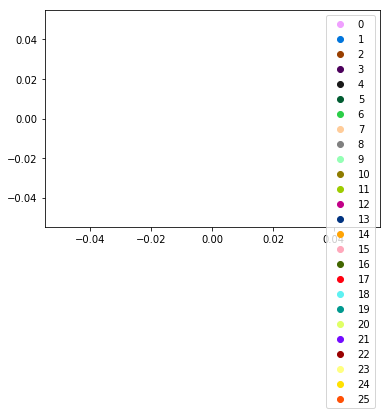

In [47]:
def DiscretePalette(n, palette=None):
    palettes={
                'alphabet':[
                  "#F0A0FF", "#0075DC", "#993F00", "#4C005C", "#191919", "#005C31",
                  "#2BCE48", "#FFCC99", "#808080", "#94FFB5", "#8F7C00", "#9DCC00",
                  "#C20088", "#003380", "#FFA405", "#FFA8BB", "#426600", "#FF0010",
                  "#5EF1F2", "#00998F", "#E0FF66", "#740AFF", "#990000", "#FFFF80",
                  "#FFE100", "#FF5005"
                ],
                'alphabet2':[
                  "#AA0DFE", "#3283FE", "#85660D", "#782AB6", "#565656", "#1C8356",
                  "#16FF32", "#F7E1A0", "#E2E2E2", "#1CBE4F", "#C4451C", "#DEA0FD",
                  "#FE00FA", "#325A9B", "#FEAF16", "#F8A19F", "#90AD1C", "#F6222E",
                  "#1CFFCE", "#2ED9FF", "#B10DA1", "#C075A6", "#FC1CBF", "#B00068",
                  "#FBE426", "#FA0087"
                ],
                'glasbey':[
                  "#0000FF", "#FF0000", "#00FF00", "#000033", "#FF00B6", "#005300",
                  "#FFD300", "#009FFF", "#9A4D42", "#00FFBE", "#783FC1", "#1F9698",
                  "#FFACFD", "#B1CC71", "#F1085C", "#FE8F42", "#DD00FF", "#201A01",
                  "#720055", "#766C95", "#02AD24", "#C8FF00", "#886C00", "#FFB79F",
                  "#858567", "#A10300", "#14F9FF", "#00479E", "#DC5E93", "#93D4FF",
                  "#004CFF", "#F2F318"
                ],
                'polychrome':[
                  "#5A5156", "#E4E1E3", "#F6222E", "#FE00FA", "#16FF32", "#3283FE",
                  "#FEAF16", "#B00068", "#1CFFCE", "#90AD1C", "#2ED9FF", "#DEA0FD",
                  "#AA0DFE", "#F8A19F", "#325A9B", "#C4451C", "#1C8356", "#85660D",
                  "#B10DA1", "#FBE426", "#1CBE4F", "#FA0087", "#FC1CBF", "#F7E1A0",
                  "#C075A6", "#782AB6", "#AAF400", "#BDCDFF", "#822E1C", "#B5EFB5",
                  "#7ED7D1", "#1C7F93", "#D85FF7", "#683B79", "#66B0FF", "#3B00FB"
                ],
                'stepped':[
                  "#990F26", "#B33E52", "#CC7A88", "#E6B8BF", "#99600F", "#B3823E",
                  "#CCAA7A", "#E6D2B8", "#54990F", "#78B33E", "#A3CC7A", "#CFE6B8",
                  "#0F8299", "#3E9FB3", "#7ABECC", "#B8DEE6", "#3D0F99", "#653EB3",
                  "#967ACC", "#C7B8E6", "#333333", "#666666", "#999999", "#CCCCCC"
                ]
            }
    if palette is None:
        if n<=26:
            palette="alphabet"
        elif n<=32:
            palette="glasbey"
        else:
            palette="polychrome"
    
    palette_array= palettes[palette]
    #print(len(palette_array))
    assert n<=len(palette_array), "Not enough colours in specified palette"

    return np.array(palette_array)[np.arange(n)]


color_list=DiscretePalette(26)
for idx,color in enumerate(color_list):
    plt.scatter([],[],c=color,label=idx)
plt.legend()
#plt.sca
#pd.DataFrame({'color':color_list,
#             'x':np.arange(len(color_list))
#             }).plot.scatter(x='x',y='x',c='color')

In [48]:
from PIL import ImageColor



def category_to_color_category(category,mode='color'):
    color=(0,0,0,256)
    if 'Hemato' in category:##
        #color=(180,5,5,256)
        color=ImageColor.getcolor(color_list[17], "RGBA")
    elif 'Anthropomet' in category:##
        #color=(5,5,180,256)
        color=ImageColor.getcolor(color_list[1], "RGBA")
    elif 'Protein' in category:##
        #color=(5,180,5,256)        
        color=ImageColor.getcolor(color_list[2], "RGBA")
    elif 'Metabolic' in category:##
        #color=(160,120,20,256)
        color=ImageColor.getcolor(color_list[3], "RGBA")
    elif 'Liver' in category:
        #color=(120,20,160,256)
        color=ImageColor.getcolor(color_list[14], "RGBA")
    elif 'Kidney' in category:##
        #color=(20,120,160,256)
        color=ImageColor.getcolor(color_list[5], "RGBA")
    elif 'Blood-pressure' in category:
        #color=(256,50,5,256)
        color=ImageColor.getcolor(color_list[6], "RGBA")
    elif 'Cardio' in category:
        color=ImageColor.getcolor(color_list[12], "RGBA")
        pass
    elif 'Thyr' in category:
        color=ImageColor.getcolor(color_list[10], "RGBA")
    elif 'Immune' in category:
        color=ImageColor.getcolor(color_list[21], "RGBA")
    elif 'Nervou' in category:
        color=ImageColor.getcolor(color_list[22], "RGBA")
    elif 'Orth' in category:
        color=ImageColor.getcolor(color_list[25], "RGBA")
        
    elif 'Canc' in category:
        color=ImageColor.getcolor(color_list[16], "RGBA")
    elif 'Eye' in category:
        color=ImageColor.getcolor(color_list[11], "RGBA")
        
    if mode=='color':
        return np.array(color)/256
    else:
        return category.replace(' disease','').replace(' QTL','')
    

In [49]:
def gene_to_color_category(gene_name,mode='color'):
    if gene_name in ['HLA-A','HLA-B','HLA-C']:
        #color='#fa3c14'
        #250, 58, 20
        color=1/256*np.array((250,58,20,256))
        category='Classical HLA gene (class I)'
    elif gene_name in ['HLA-DPA1', 'HLA-DPB1','HLA-DQA1', 'HLA-DQB1','HLA-DRB1','HLA-DRA']:
        #color='#2850c8'
        color=1/256*np.array((40, 80, 200,256))
        category='Classical HLA gene (class II)'
    elif gene_name in ['HLA-F', 'HLA-G', 'HLA-E', 'HLA-DRB5', 'HLA-DQA2', 'HLA-DQB2', 'HLA-DOB', 'HLA-DMB', 'HLA-DMA', 'HLA-DOA', 'MICA','MICB','TAP2','TAP1']:
        #color='#28c828'
        color=1/256*np.array((40, 200, 40,256))
        category='Nonclassical HLA gene'
    else:
        #color='#fafac8'
        color=1/256*np.array((250, 250, 200,256))
        color[:3]=color[:3]*0.1
        color=1/256*np.array((0, 0, 0,256))
        category='Other genes'
    if mode=='color':
        return color
    elif mode=='category':
        return category

In [50]:
dftemp=pd.DataFrame(index=HLA_result_heatmap_significant.columns)
dftemp['color']=HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'color'))
dftemp['category']=HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'category'))
dftemp['x']=np.arange(len(dftemp))

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single 

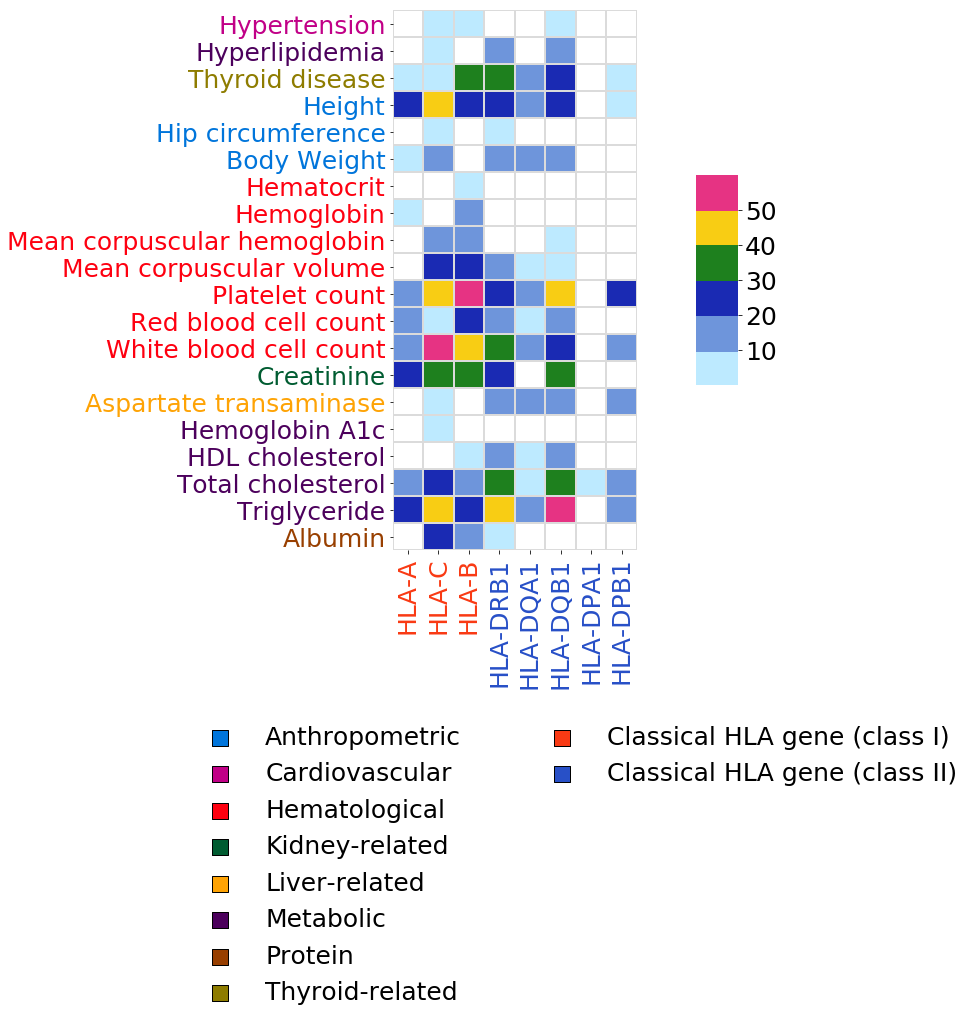

In [51]:
plt.rcParams['font.family']='Arial'
plt.rcParams["font.size"] = 25


import matplotlib.gridspec as gridspec
import seaborn as sns


fig = plt.figure(figsize=(5+1+2, 10+3+4)) 


gs=fig.add_gridspec(10+3+4,5+1+3)

fig_heatmap=fig.add_subplot(gs[0:10,0:5])
fig_heatmap_cmap=fig.add_subplot(gs[0+3:10-3, 5+1:5+1+1])

sns.heatmap(HLA_result_heatmap_significant,
            ax=fig_heatmap,
            cmap=custom_cmap,
            vmin=0,
            vmax=60,
            linewidths=1,
            linecolor=np.array([220,220,220,256])/256,
            cbar_ax=fig_heatmap_cmap,
            cbar_kws={'fraction':0.1, "ticks":[10, 20, 30, 40, 50]},
            cbar=True,
            alpha=1,edgecolor='black')

fig_heatmap.set_ylabel('')
fig_heatmap.set_xlabel('')

for ticklabel in fig_heatmap.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))
fig_heatmap.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_heatmap.get_yticklabels()])


for ticklabel in fig_heatmap.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color_category(gene_name,'color'))
    

fig_legend=fig.add_subplot(gs[10+3:10+3+4, 0:5])


category_color_df=pd.DataFrame([phenotype_info.loc[HLA_result_heatmap_significant.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[HLA_result_heatmap_significant.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(-0.9, 1.1),frameon=False
    
)

#print(category_color_df.head())
fig_legend.axis("off")
category_color_df=pd.DataFrame([HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'category')),
                            HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'color')),
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend2=fig_legend.legend(
                    [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                    [row['category'] for (idx,row) in category_color_df.iterrows()],
                   loc='upper left',bbox_to_anchor=(0.5, 1.1),frameon=False
    
)


#print(category_color_df.head())
plt.gca().add_artist(legend1)

fig_legend.axis("off")
#fig_legend.legend()

plt.style.use('default')

plt.savefig(data_out_pub_path+'HLA_omnibus.png', bbox_inches='tight')
  

# Matrix

In [149]:
phewas_data=result_all_pub[ (result_all_pub['P_significant']==1) ][['phenotype_name','gene','P']]
phewas_data.shape


(69, 3)

In [150]:
phewas_data[phewas_data['phenotype_name']=='hematocrit']

,phenotype_name,gene,P
Unnamed: 0.1,,,
314361,hematocrit,AGER,9.197860e-13
291010,hematocrit,HLA-B,1.049540e-09
267912,hematocrit,HLA-F,9.911020e-09


In [151]:
#phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','RNF5',9.197860e-13]
#phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','AGER',9.197860e-13]
#phewas_data=phewas_data[~((phewas_data['phenotype_name']=='hematocrit') &(phewas_data['gene']=='RNF5,AGER'))]
phewas_data.shape

(69, 3)

In [113]:
phewas_data[phewas_data['phenotype_name']=='hematocrit']

,phenotype_name,gene,P
Unnamed: 0.1,,,
314361,hematocrit,AGER,9.197860e-13
291010,hematocrit,HLA-B,1.049540e-09
267912,hematocrit,HLA-F,9.911020e-09


In [114]:
phewas_data[phewas_data.duplicated(['phenotype_name','gene'],keep=False)]

,phenotype_name,gene,P
Unnamed: 0.1,,,
339246,hdl_cholesterol,BTNL2,1.434950e-14
376310,hdl_cholesterol,BTNL2,1.466540e-10
583434,platelet,BAK1,1.579220e-69
648220,platelet,BAK1,2.417650e-35
454437,thyroid_disease,HLA-DQA1,9.949160e-22
1316160,thyroid_disease,HLA-DQA1,5.128710e-11


In [152]:
phewas_data=phewas_data[~phewas_data.duplicated(['phenotype_name','gene'])]
phewas_data.shape

(66, 3)

In [153]:
phewas_data_2d=phewas_data.pivot(index='phenotype_name',columns='gene',values='P')

In [154]:
phewas_data_2d.loc['hdl_cholesterol']

gene
AGER                 NaN
ATF6B                NaN
BAG6                 NaN
BAK1                 NaN
BTNL2       1.434950e-14
C2                   NaN
C6orf1               NaN
C6orf10              NaN
C6orf100             NaN
HLA-A                NaN
HLA-B                NaN
HLA-C                NaN
HLA-DPB1             NaN
HLA-DQA1             NaN
HLA-DQB1             NaN
HLA-DRB1             NaN
HLA-E                NaN
HLA-F                NaN
HMGA1                NaN
MICA                 NaN
MICB                 NaN
MUC22                NaN
NOTCH4               NaN
OR2J2                NaN
POU5F1               NaN
TAF11                NaN
TCF19                NaN
TRIM27               NaN
UBD                  NaN
UHRF1BP1    6.678210e-10
Name: hdl_cholesterol, dtype: float64

In [155]:
phewas_data_2d=phewas_data_2d.applymap(lambda x: -np.log10(x))

In [156]:
phewas_data_2d=phewas_data_2d[gene_bed.set_index('Gene name').loc[phewas_data_2d.columns].sort_values('Gene start (bp)').index]
phewas_data_2d=phewas_data_2d.loc[phenotype_info.loc[phewas_data_2d.index].sort_values(['phenotype_type','phenotype_category']).index]
#phewas_data_2d.index=phenotype_info.loc[phewas_data_2d.index]['phenotype_name_publication']

In [157]:
gene_bed.set_index('Gene name').loc['C2']

Gene stable ID                                                                  ENSG00000166278
Gene stable ID version                                                       ENSG00000166278.10
Transcript stable ID                                                            ENST00000469372
Transcript stable ID version                                                  ENST00000469372.1
Gene start (bp)                                                                        31865562
Gene end (bp)                                                                          31913449
Transcript start (bp)                                                                  31865562
Transcript end (bp)                                                                    31913298
Protein stable ID                                                               ENSP00000418923
Protein stable ID version                                                     ENSP00000418923.1
Gene description                        

In [158]:
phewas_data_2d_count=(phewas_data_2d>0).sum().to_frame().reset_index()
phewas_data_2d_count['color']=phewas_data_2d_count['gene'].map(lambda x: gene_to_color_category(x,'color'))

In [159]:
phewas_data_2d_count

,gene,0,color
0,TRIM27,2,"[0.0, 0.0, 0.0, 1.0]"
1,C6orf100,1,"[0.0, 0.0, 0.0, 1.0]"
2,OR2J2,1,"[0.0, 0.0, 0.0, 1.0]"
3,UBD,1,"[0.0, 0.0, 0.0, 1.0]"
4,HLA-F,2,"[0.15625, 0.78125, 0.15625, 1.0]"
5,HLA-A,3,"[0.9765625, 0.2265625, 0.078125, 1.0]"
6,HLA-E,1,"[0.15625, 0.78125, 0.15625, 1.0]"
7,MUC22,1,"[0.0, 0.0, 0.0, 1.0]"
8,TCF19,1,"[0.0, 0.0, 0.0, 1.0]"
9,POU5F1,1,"[0.0, 0.0, 0.0, 1.0]"


In [160]:
result_all_pub[(result_all_pub['phenotype_name']==row)&(result_all_pub['gene']==col)]

ValueError: Can only compare identically-labeled Series objects

In [161]:
print(1)

1


In [162]:
phewas_data_2d_noveltycheck=phewas_data_2d.copy()

for row, row_data in phewas_data_2d_noveltycheck.iterrows():
    for col,element in row_data.items():
        #print(row,co)
        if ~np.isnan(element):
            select=result_all_pub[(result_all_pub['phenotype_name']==row)&(result_all_pub['gene']==col)]
            if len(select)!=1:
                print(select[['phenotype_name','gene']])
            if select['novel'].sum()!=0:
                phewas_data_2d_noveltycheck.loc[row,col]=1
            else:
                phewas_data_2d_noveltycheck.loc[row,col]=np.nan

               phenotype_name      gene
Unnamed: 0.1                           
454437        thyroid_disease  HLA-DQA1
1316160       thyroid_disease  HLA-DQA1
             phenotype_name  gene
Unnamed: 0.1                     
583434             platelet  BAK1
648220             platelet  BAK1
               phenotype_name   gene
Unnamed: 0.1                        
339246        hdl_cholesterol  BTNL2
376310        hdl_cholesterol  BTNL2


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

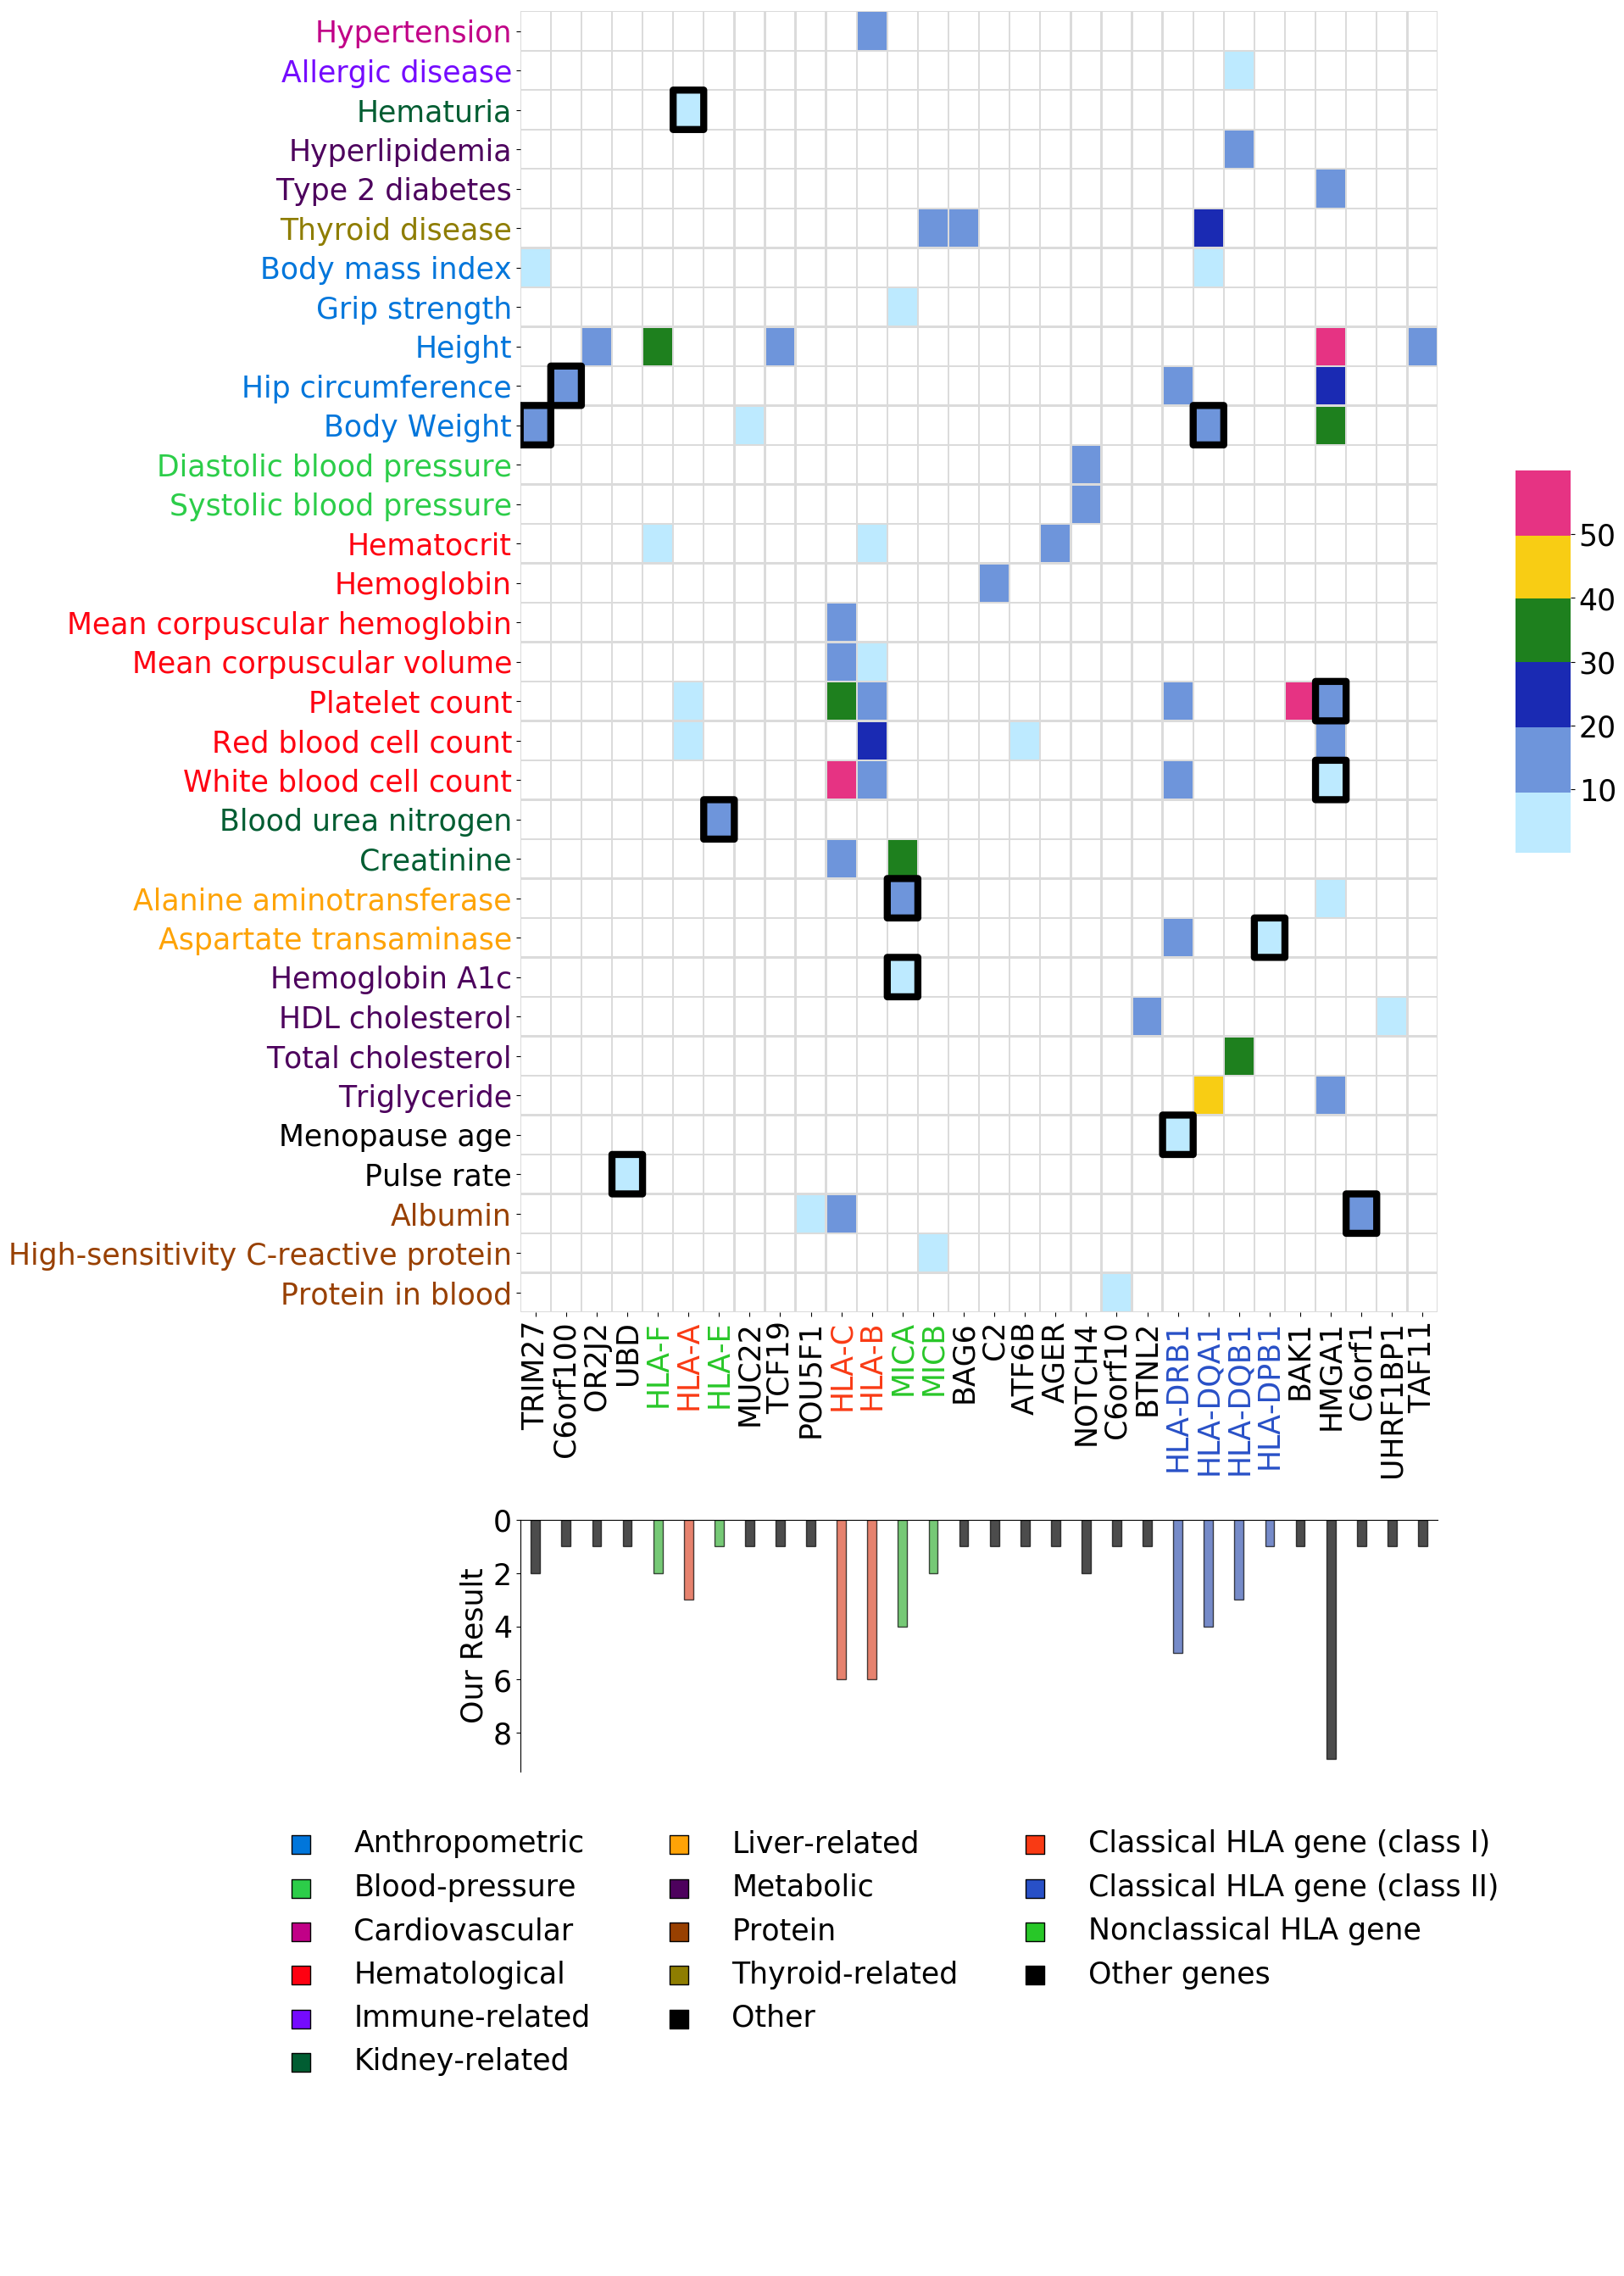

In [163]:
plt.rcParams["figure.figsize"] = (10,15)
plt.rcParams["font.size"] = 25
plt.rcParams['font.family']='Arial'

import matplotlib.gridspec as gridspec
import seaborn as sns

#fig = plt.figure(figsize=(10, 15+3)) 
fig = plt.figure(figsize=(13+1+3, 20+3+4+3+4)) 
gs=fig.add_gridspec(20+3+4+3+4,13+1+3)



#fig_barplot=fig.add_subplot(gs[20:24,0:13])

#gs = gridspec.GridSpec(3, 2, height_ratios=[5, 0.05, 1], width_ratios=[10,1]) 


fig_heatmap=fig.add_subplot(gs[0:20,0:14])
fig_heatmap_cmap=fig.add_subplot(gs[0+7:20-7, 14+1:14+1+1])


sns.heatmap(phewas_data_2d,
            ax=fig_heatmap,
            cmap=custom_cmap,
            vmin=0,
            vmax=60,
            xticklabels=True,
            linewidths=1,
            linecolor=np.array([220,220,220,256])/256,
            cbar_ax=fig_heatmap_cmap,
            cbar_kws={'fraction':0.1, "ticks":[10, 20, 30, 40, 50]},
            cbar=True,
            alpha=1,edgecolor='black')#,legend=None)
##fig.delaxes(fig_heatmap)
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator,MaxNLocator
#from matplotlib import ticker
#tick_locator = ticker.MaxNLocator(10)
#ax.xaxis.set_minor_locator(AutoMinorLocator())
#fig_barplot.minorticks_on()
#ax.xaxis.set_minor_locator(MultipleLocator(0.005))


#fig_heatmap.xaxis.set_major_locator(MaxNLocator(200))
fig_heatmap.set_ylabel('')
fig_heatmap.set_xlabel('')

for ticklabel in fig_heatmap.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))
fig_heatmap.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_heatmap.get_yticklabels()])

for ticklabel in fig_heatmap.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color_category(gene_name,'color'))


custom_cmap_white = ListedColormap([[1,1,1,0],
                                    [1,1,1,0],
                                    [1,1,1,0],
                                   ])    
#ax=sns.heatmap(phewas_data_2d_noveltycheck, ax=ax, cmap=custom_cmap_white, vmin=0, vmax=1, linecolor=None, cbar=False, alpha=0.7)#,legend=None)    
fig_heatmap.pcolor(phewas_data_2d_noveltycheck.values, cmap=custom_cmap_white, facecolor=None, edgecolors='black', linewidths=6)#, ax=ax)    
  
    

fig_barplot=fig.add_subplot(gs[20+3:20+3+4,0:14])    
"""
sns.barplot(x='index',y='gene_name',ax=fig_barplot,data=phewas_data_2d_columns_catalog_all_count,
            edgecolor='black',
            palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.3)    
"""
fig_barplot.xaxis.set_visible(False)
fig_barplot.spines['right'].set_visible(False)
fig_barplot.spines['bottom'].set_visible(False)
#fig_barplot.set_ylim(fig_barplot.get_ylim()[::-1])
#fig_barplot.set_ylabel('GWAS Catalog')


fig_barplot2 = fig_barplot#.twinx() 
sns.barplot(x='gene',y=0,data=phewas_data_2d_count,
            edgecolor='black',
            palette=list(phewas_data_2d_count['color'].values),alpha=0.7,ax=fig_barplot2)
fig_barplot2.set_ylim(fig_barplot2.get_ylim()[::-1])
#fig_barplot2.set_ylabel('Our Result (thin)')
fig_barplot2.set_ylabel('Our Result')


for bar in fig_barplot2.patches:
    newwidth=0.3
    
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)

    
#fig_legend=fig.add_subplot(gs[20+3+2:20+3+2+4,0:14])
fig_legend=fig.add_subplot(gs[20+3+4+3:20+3+4+3+4, 0:14])    


category_color_df=pd.DataFrame([phenotype_info.loc[phewas_data_2d.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[phewas_data_2d.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(-0.3, 1.7),frameon=False,
    ncol=2
)

#print(category_color_df.head())
fig_legend.axis("off")
category_color_df=pd.DataFrame([phewas_data_2d.columns.map(lambda x: gene_to_color_category(x,'category')),
                            phewas_data_2d.columns.map(lambda x: gene_to_color_category(x,'color')),
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend2=fig_legend.legend(
                    [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                    [row['category'] for (idx,row) in category_color_df.iterrows()],
                   loc='upper left',bbox_to_anchor=(0.5, 1.7),frameon=False   #0.4
)
#print(category_color_df.head())
plt.gca().add_artist(legend1)

plt.style.use('default')
plt.savefig(data_out_pub_path+'phewas.png', bbox_inches='tight')

In [ ]:
print(1)

# univar

In [209]:
result_list=[]
for phenotype_name in binary_continuous_traits:
    #pheno[pheno['pheno']!=-9].to_csv(data_out_gcta_path+phenotype_name+'.phe',sep='\t',index=None,header=None)
    try:
        result=pd.read_csv('data/out_gcta/{}.HEreg'.format(phenotype_name),skiprows=[0,5,6,7,8],sep=r'\s+',index_col=0)
        result=result.astype(float)
        result=result.unstack().to_frame().sort_index(level=1).T
    except:
        print(phenotype_name,'pass')
        continue

    result.columns = result.columns.map(lambda x: '-'.join(x[::-1]))
    result.index=[phenotype_name]#[result_file.split('/')[-1].split('.')[0]]

    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',header=None,names=['FID','IID','pheno'])
    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
        
    result['phenotype_type']=phenotype_type
    #print(result.columns)
    if phenotype_type=='binary':
        with open(data_out_pheno_path+phenotype_name+'.phe'+'.prev','r') as f:
            prev=float(f.read())
        #print('prev',prev)   
        result['prevalence']=prev
    result_list.append(result)  

In [210]:
from scipy.stats import norm
def h2_obs_to_liab(h2_obs, P, K):
    '''
    Converts heritability on the observed scale in an ascertained sample to heritability
    on the liability scale in the population.
    Parameters
    ----------
    h2_obs : float
        Heritability on the observed scale in an ascertained sample.
    P : float in (0,1)
        Prevalence of the phenotype in the sample.
    K : float in (0,1)
        Prevalence of the phenotype in the population.
    Returns
    -------
    h2_liab : float
        Heritability of liability in the population.
    '''
    if np.isnan(P) and np.isnan(K):
        return h2_obs
    if K <= 0 or K >= 1:
        raise ValueError('K must be in the range (0,1)')
    if P <= 0 or P >= 1:
        raise ValueError('P must be in the range (0,1)')

    thresh = norm.isf(K)
    conversion_factor = K ** 2 * \
        (1 - K) ** 2 / (P * (1 - P) * norm.pdf(thresh) ** 2)
    return h2_obs * conversion_factor

In [211]:
result_uni=pd.concat(result_list)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [212]:
result_uni['h2_liab']=result_uni.apply(lambda row: h2_obs_to_liab(row['V(G)/Vp-Estimate'],row['prevalence'],row['prevalence']) if row['phenotype_type']=='binary' else row['V(G)/Vp-Estimate'],axis=1)

In [213]:
#result=pd.read_csv('data/out_gcta/{}.HEreg'.format(phenotype_name),skiprows=[0,5,6,7,8],sep=r'\s+',index_col=0)
#result_concat

In [214]:
result_uni.to_csv('data/gcta_result_uni.tsv',sep='\t')

In [215]:
toplot

NameError: name 'toplot' is not defined

In [218]:
result_concat=result_uni

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with 

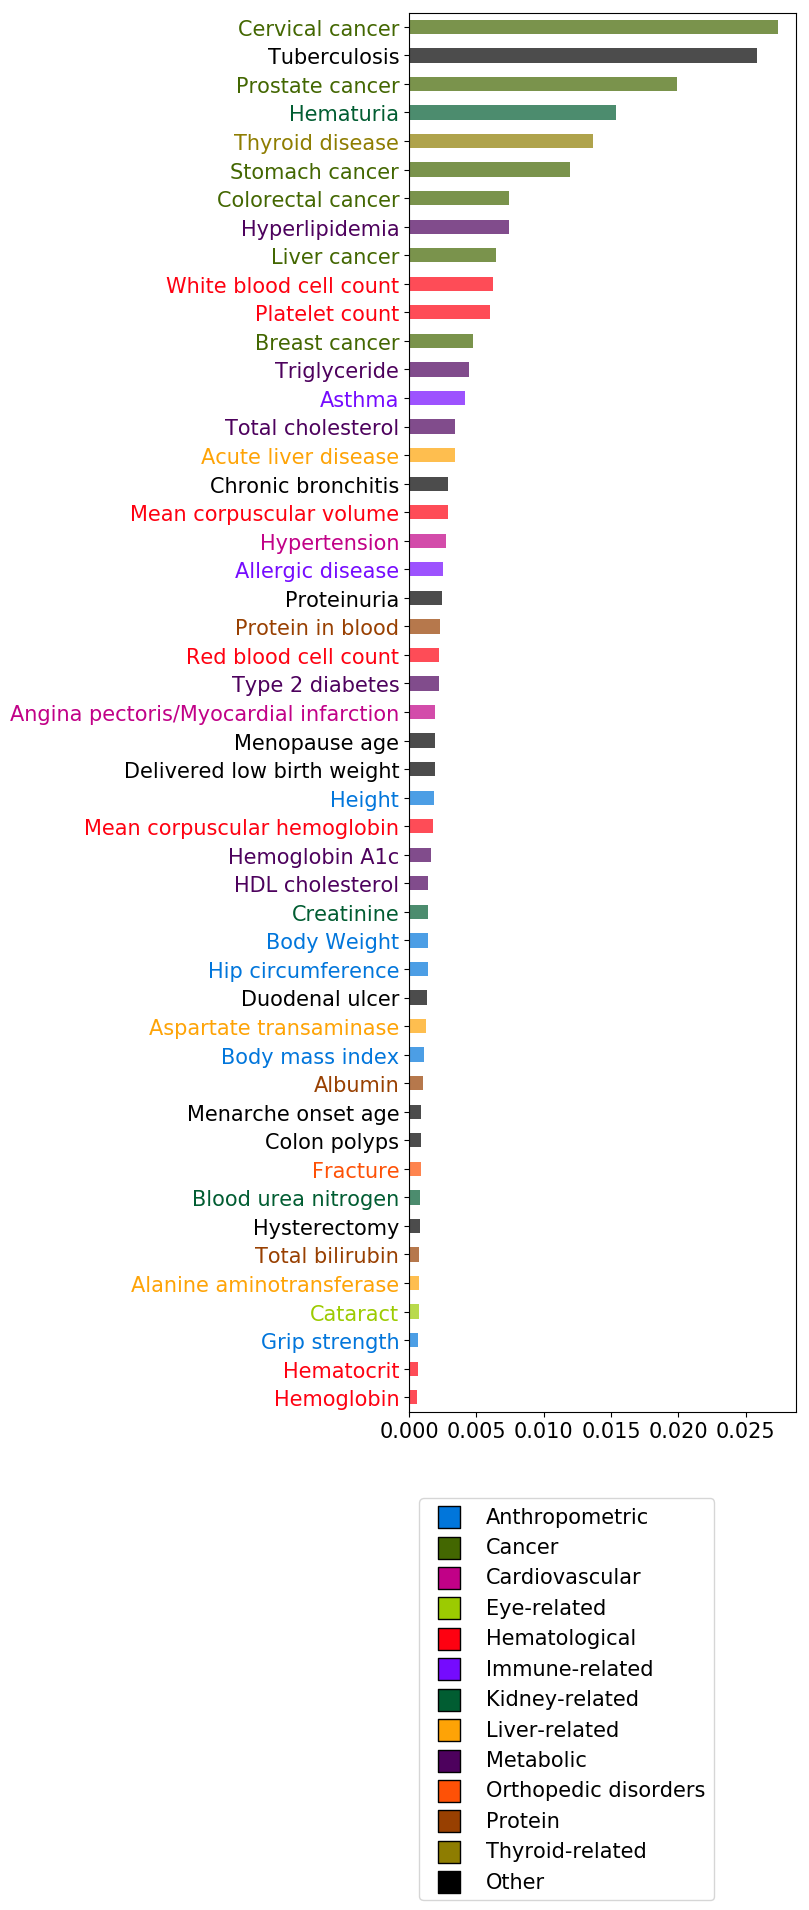

In [219]:
toplot=result_concat[result_concat['h2_liab']>0].copy()
toplot=toplot.sort_values('h2_liab',ascending=True).iloc[int(3*len(toplot)/10):]
toplot['color']=toplot.index.map(lambda x: category_to_color_category(phenotype_info.loc[x]['phenotype_category'],'color'))

#plt.rcParams["figure.figsize"] = (5,30)
plt.rcParams["font.size"] = 15


fig = plt.figure(figsize=(5, 20)) 
gs=fig.add_gridspec(20+2,5)
#ax=fig.add_subplot(1,1,1)

fig_barplot=fig.add_subplot(gs[0:20,0:5])
"""
sns.barplot(
    x='h2_liab',
    y=0,
    data=toplot,
    ax=ax
)
"""
toplot['h2_liab'].plot.barh(linewidth=0.1,
                            colors=list(toplot['color'].values),
                            alpha=0.7,
                            ax=fig_barplot)

for ticklabel in fig_barplot.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))

fig_barplot.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_barplot.get_yticklabels()])






fig_legend=fig.add_subplot(gs[20:20+2, 0:5])   

category_color_df=pd.DataFrame([phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])

legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(0, 0.5)
)


fig_legend.axis("off")


plt.savefig(data_out_pub_path+'h2_uni.png', bbox_inches='tight')
#plt.savefig('figure_h2.svg', bbox_inches='tight')

# bivar

In [220]:
rG_matrix_upper=np.zeros((len(result_uni),len(result_uni)))
rG_SE_matrix_upper=np.zeros((len(result_uni),len(result_uni)))

In [221]:
for i in range(0,len(result_uni)):
    for j in range(i+1,len(result_uni)):
        phenotype_name1=result_uni.iloc[i].name
        phenotype_name2=result_uni.iloc[j].name


        if os.path.exists(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.HEreg'):
            pass
        elif os.path.exists(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.HEreg'):
            (phenotype_name2,phenotype_name1)=phenotype_name1,phenotype_name2
        elif os.path.exists(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.log'):
            #print(phenotype_name1,phenotype_name2,'missing')
            with open(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.log') as f:
                if 'no phenotype data is found' in f.read():
                    continue
        elif os.path.exists(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.log'):
            #print(phenotype_name1,phenotype_name2,'missing')
            with open(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.log') as f:            
                if 'no phenotype data is found' in f.read():
                    continue            
        else:
            print(phenotype_name1,phenotype_name2)
            continue
            
        #result1=pd.read_csv(data_out_gcta_path+'{}.HEreg'.format(phenotype_name1),skiprows=[0,1,2,3,4,5],sep=r'\s+').set_index('Coefficient')#,skiprows=[0,1],sep=r'\s*')
        #result2=pd.read_csv(data_out_gcta_path+'{}.HEreg'.format(phenotype_name2),skiprows=[0,1,2,3,4,5],sep=r'\s+').set_index('Coefficient')#,skiprows=[0,1],sep=r'\s*')
        #pd.read_csv(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.phe',sep='\t',header=None)
        
        result_bivar=pd.read_csv(data_out_gcta_path+'{}-{}.HEreg'.format(phenotype_name1,phenotype_name2),skiprows=[0,1],sep=r'\s+').set_index('Coefficient')
        rG_matrix_upper[i][j]=result_bivar.loc['rG']['Estimate']
        rG_SE_matrix_upper[i][j]=result_bivar.loc['rG']['SE_OLS']        
        

In [222]:
def make_tri(mat):
    upper1=np.triu(mat,k=1)
    upper2=np.triu(mat.T,k=1) 
    
    ret=upper1+upper2 - np.where((upper1==upper2), upper1, 0)
    ret=np.triu(ret,k=1)
    return ret

In [262]:
rG_matrix=make_tri(rG_matrix_upper)
rG_abs_matrix=np.abs(rG_matrix)
rG_SE_matrix=make_tri(rG_SE_matrix_upper)
rG_Z_abs_matrix=np.abs(rG_matrix/rG_SE_matrix)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [263]:
rG_matrix_df=pd.DataFrame(rG_matrix,index=result_uni.index,columns=result_uni.index)
rG_abs_matrix_df=pd.DataFrame(rG_abs_matrix,index=result_uni.index,columns=result_uni.index)
#rG_Z_matrix_df=pd.DataFrame(rG_Z_matrix,index=result_uni.index,columns=result_uni.index)
rG_Z_abs_matrix_df=pd.DataFrame(rG_Z_abs_matrix,index=result_uni.index,columns=result_uni.index)
rG_SE_matrix_df=pd.DataFrame(rG_SE_matrix,index=result_uni.index,columns=result_uni.index)

In [264]:
edges=rG_matrix_df.mask(np.tril(np.ones(rG_matrix_df.shape)).astype(np.bool)).stack()
edges=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges.iteritems()],columns=['source','target','rG'])

In [265]:
edges2=rG_Z_abs_matrix_df.mask(np.tril(np.ones(rG_Z_abs_matrix_df.shape)).astype(np.bool)).stack()
edges2=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges2.iteritems()],columns=['source','target','Z_abs'])

In [266]:
edges3=rG_abs_matrix_df.mask(np.tril(np.ones(rG_abs_matrix_df.shape)).astype(np.bool)).stack()
edges3=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges3.iteritems()],columns=['source','target','rG_abs'])

In [267]:
edges=edges.merge(right=edges2,left_on=['source','target'],right_on=['source','target']).merge(right=edges3,left_on=['source','target'],right_on=['source','target'])

In [293]:
#edges_filtered=edges.sort_values('Z_abs',ascending=False).iloc[:int(len(edges)*0.03)]#edges[edges['value']>2]
edges_filtered=edges.sort_values('Z_abs',ascending=False).iloc[:int(len(edges)*0.035)]#edges[edges['value']>2]

In [294]:
edges_filtered.shape

(80, 5)

In [295]:
#edges_filtered=edges_filtered.sort_values('rG_abs',ascending=True)#.iloc[:int(len(edges)*0.03)]#edges[edges['value']>2]
edges_filtered=edges_filtered[edges_filtered['rG_abs']>0.3]
edges_filtered.shape

(77, 5)

In [296]:
groups=[]
for idx,row in edges_filtered.iterrows():
    try:
        group_index=[(row['source'] in groups[i] or row['target'] in groups[i]) for i in range(len(groups))].index(True)
        groups[group_index].add(row['source'])
        groups[group_index].add(row['target'])
    except:
        groups.append({row['source'],row['target']})

In [297]:
groups=sorted(groups,key=lambda x: len(x),reverse=True)

In [298]:
len(groups)

2

In [299]:
#phenotypes_par_filtered['group_id']=
edges_filtered['group_id']=[np.argmax([False]+[row['source'] in group for group in groups]) for idx,row in edges_filtered.iterrows()]

In [300]:
import networkx as nx

In [301]:
edges_filtered[edges_filtered['group_id']==2]

,source,target,rG,Z_abs,rG_abs,group_id


In [302]:
edges_filtered_filtered=edges_filtered[edges_filtered['group_id']==1]
#edges_filtered_filtered=edges_filtered

G_temp=nx.convert_matrix.from_pandas_edgelist(edges_filtered_filtered,edge_attr=['rG','rG_abs','Z_abs'])

#per_bp_var_temp=per_bp_var.copy()
#per_bp_var_temp.index=per_bp_var_temp.index.map(lambda x:description_to_short(code_to_description(x),'pub',2))
nx.set_node_attributes(G_temp,dict([(node,pd.Series(result_uni['V(G)/Vp-Estimate'].loc[node]).iloc[0]) for node in list(G_temp.nodes)]),'heritability')
#nx.set_node_attributes(G_temp,dict([(node,node) for node in list(G.nodes)]),'label')

In [303]:
#G=nx.relabel_nodes(G_temp,lambda x: description_to_short(code_to_description(x),'pub',2))

G=G_temp.copy()#nx.relabel_nodes(G_temp,lambda x:description_to_short(code_to_description(x),'abbr_pub_ori','correlation'))
#pos = nx.kamada_kawai_layout(G,weight='Z_abs')
pos = nx.spring_layout(G,weight='Z_abs')

In [304]:
plt.rcParams["figure.figsize"] = (30,30)
plt.rcParams["font.size"] = 10
#sns.heatmap(rG_matrix_df, annot=True,cmap=plt.get_cmap('PiYG'),center=0,vmin=-1,vmax=1)

In [305]:
import random

angle_map=lambda x: (np.arctan(x[1]/x[0])+(np.pi if x[0]<0 else 0)+2*np.pi)%(2*np.pi)

def draw_arc(a,b):

    center=(a+b)/2+(1 if random.random()>0.5 else -1)*np.array([(b-a)[1],-(b-a)[0]])*random.uniform(np.sqrt(3)/2,2)

    radius=np.sqrt(np.power(b-center,2).sum())

    a_theta=angle_map(a-center)#arctan_norm((a-center)[1]/(a-center)[0])
    b_theta=angle_map(b-center)
    
    if abs(b_theta-a_theta)>np.pi:
        if a_theta>b_theta:
            a_theta=a_theta-2*np.pi
        else:
            b_theta=b_theta-2*np.pi
            
    try:
        return [center+radius*np.array([np.cos(theta),np.sin(theta)]) for theta in np.arange(min(a_theta,b_theta),max(a_theta,b_theta),abs(b_theta-a_theta)/100)]
    except:
        print('error')
        return [a,b]

#draw_arc(np.array((0,1)),np.array((1,0)))

In [306]:

phenotype_info.loc[node_df.index]['phenotype_category']

total_cholesterol                     Metabolic QTL
triglyceride                          Metabolic QTL
height                           Anthropometric QTL
platelet                          Hematological QTL
hyperlipidemia                    Metabolic disease
creatinine                       Kidney-related QTL
wbc                               Hematological QTL
rbc                               Hematological QTL
thyroid_disease             Thyroid-related disease
mcv                               Hematological QTL
hypertension                 Cardiovascular disease
hip_circumference                Anthropometric QTL
weight                           Anthropometric QTL
mch                               Hematological QTL
bun                              Kidney-related QTL
hdl_cholesterol                       Metabolic QTL
diastolic_blood_pressure         Blood-pressure QTL
bmi                              Anthropometric QTL
hba1c                                 Metabolic QTL
hemoglobin  

In [307]:
#[i[0] for i in edge_df['source_xy'].values]

In [308]:
scatter_hue.max(),scatter_hue.min()

(0.0062347999999999995, 0.000471295)

In [309]:
edge_df[edge_color].abs().max(),edge_df[edge_color].max()

(1.09429, 1.09429)

<Figure size 1500x2000 with 0 Axes>

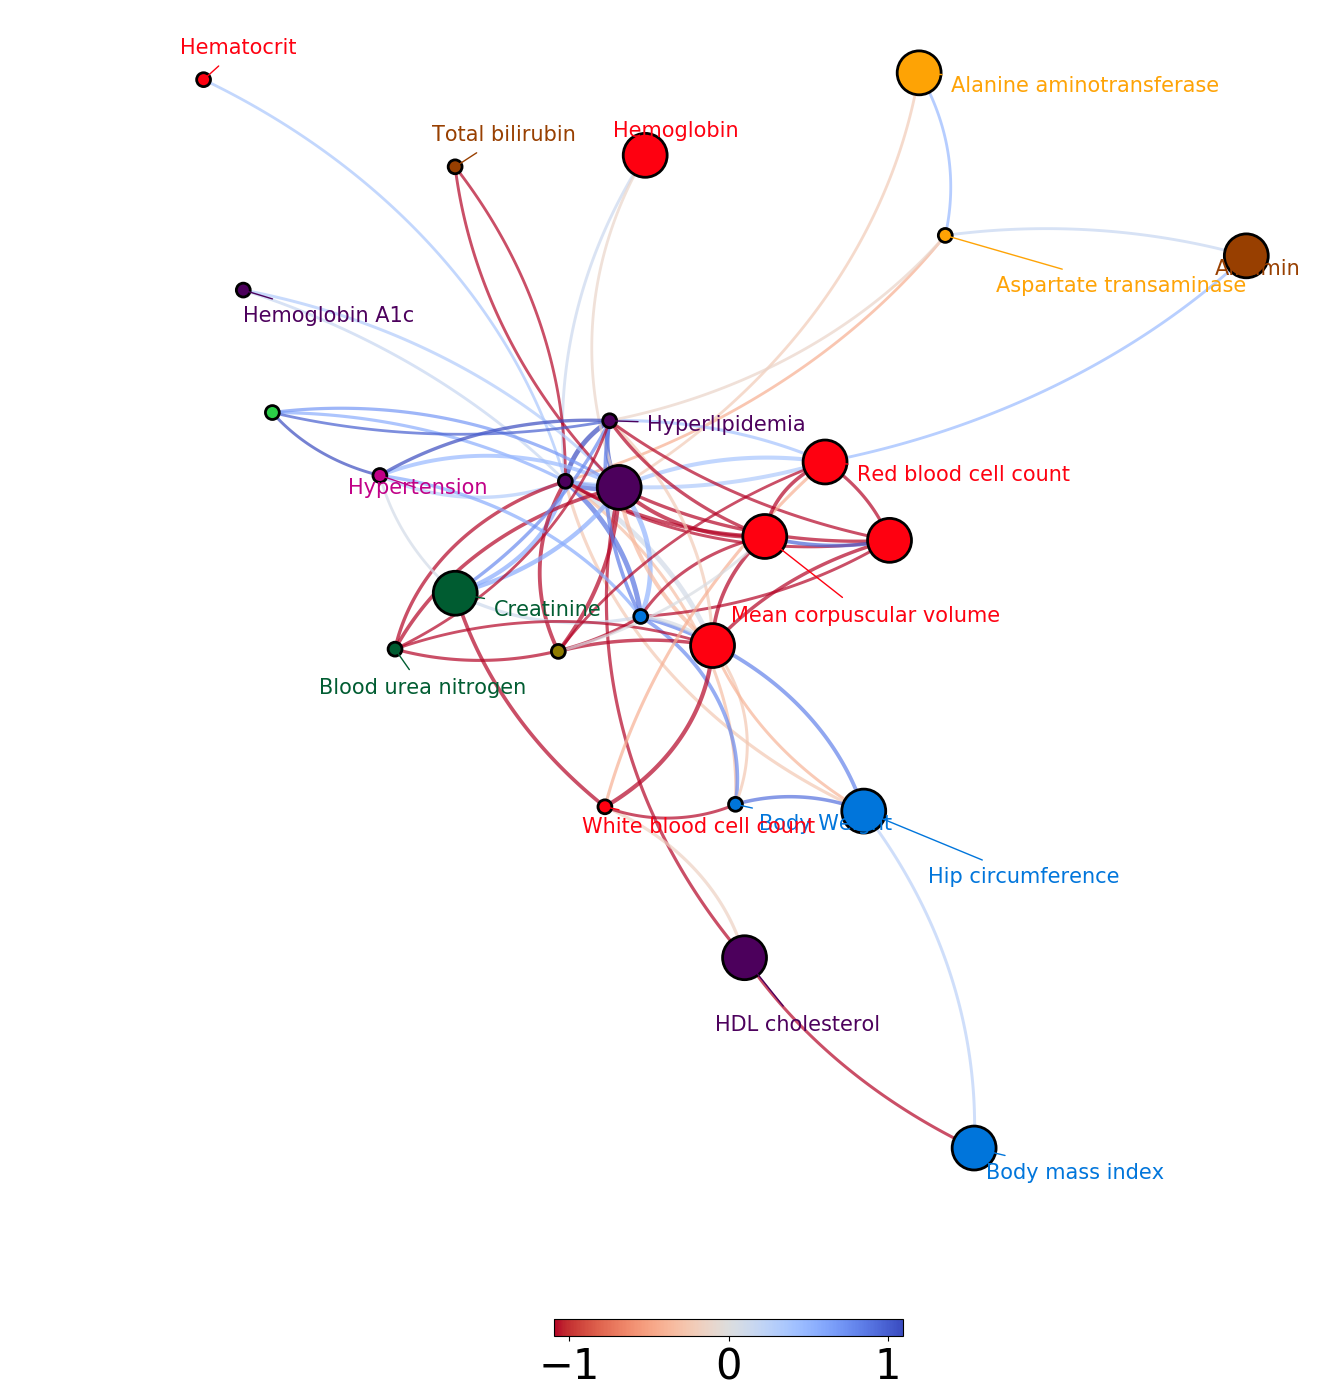

In [310]:
node_color='heritability'
node_size='heritability'

edge_width='Z_abs'
edge_color='rG'

from matplotlib.collections import LineCollection

plt.rcParams["figure.figsize"] = (15,20)
plt.rcParams["font.size"] = 30


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
"""
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.PiYG)
        
plt.clf()
"""   

#,[
scatter_x=[i[0] for i in edge_df['source_xy'].values]
scatter_y=[i[1] for i in edge_df['source_xy'].values]
scatter_hue=edge_df[edge_color].copy()
scatter_hue.iloc[[0,1]]=[-scatter_hue.abs().max(),scatter_hue.abs().max()]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.coolwarm.reversed())
        
plt.clf()
  

fig, ax = plt.subplots()

plt.colorbar(points,orientation="horizontal",pad=0.07,shrink=0.3)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=2+3*line_collection_linewidths

line_collection_colors=np.array([plt.cm.coolwarm.reversed()(row[edge_color],alpha=0.7) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=ax.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
plt.scatter(x=scatter_x,
            y=scatter_y,
            c=list(phenotype_info.loc[node_df.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values),
            alpha=1,
            s=scatter_size,
            edgecolor='black',
            linewidth=2,
            sizes=(100,1000))#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    #description_short=idx
    
    s=phenotype_info.loc[idx]['phenotype_name_publication']
    color=category_to_color_category(phenotype_info.loc[idx]['phenotype_category'],'color')
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            plt.annotate(s,
                         xy=xy,
                         color=color,
                         xytext=xytext,
                         arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0",ls=None,color=color),
                         bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0), ec="None", lw=0.3),
                         size=15)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True)
plt.axis('off')

#plt.show()
plt.savefig(data_out_pub_path+'h2_bivar.svg', bbox_inches='tight')



In [311]:
import matplotlib as mpl

In [314]:
#G=nx.relabel_nodes(G_temp,lambda x: description_to_short(code_to_description(x),'pub',2))

G=G_temp.copy()#nx.relabel_nodes(G_temp,lambda x:description_to_short(code_to_description(x),'abbr_pub_ori','correlation'))
#pos = nx.kamada_kawai_layout(G,weight='Z_abs')
pos = nx.spring_layout(G,weight='Z_abs')

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with 

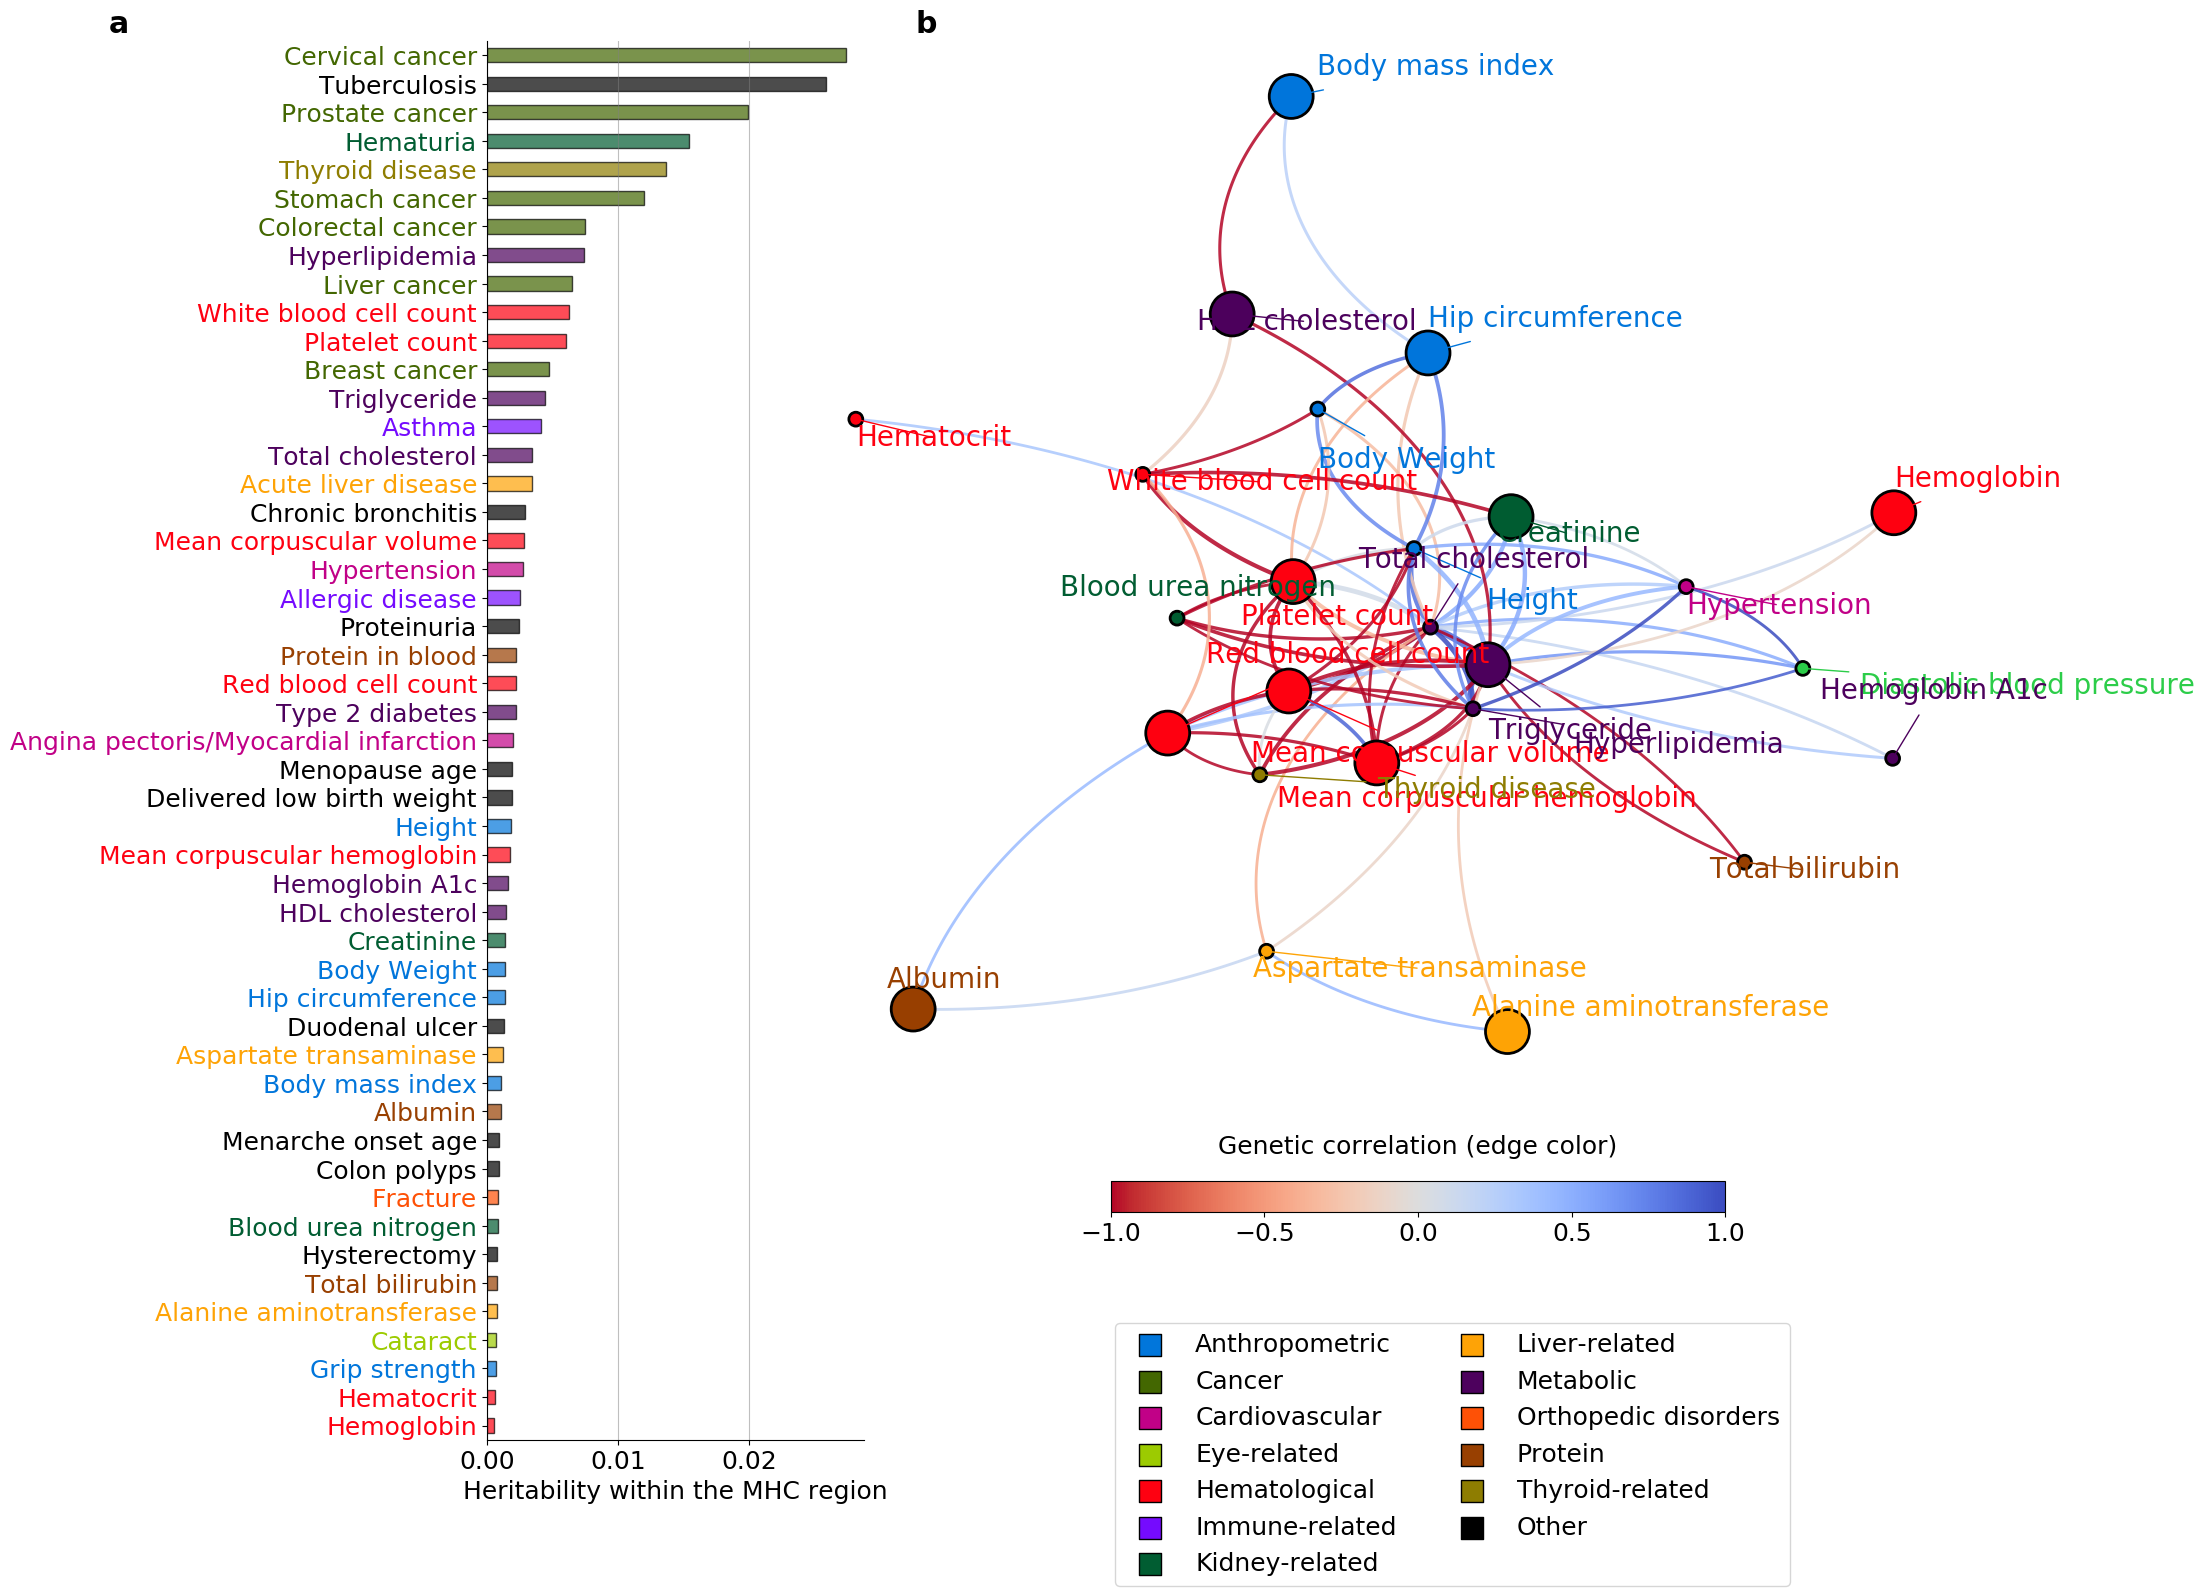

In [315]:
fig = plt.figure(figsize=(5+15, 20)) 
gs=fig.add_gridspec(20+2,5+15)


toplot=result_concat[result_concat['h2_liab']>0].copy()
toplot=toplot.sort_values('h2_liab',ascending=True).iloc[int(3*len(toplot)/10):]
toplot['color']=toplot.index.map(lambda x: category_to_color_category(phenotype_info.loc[x]['phenotype_category'],'color'))

#plt.rcParams["figure.figsize"] = (5,30)
plt.rcParams["font.size"] = 18



#ax=fig.add_subplot(1,1,1)

fig_barplot=fig.add_subplot(gs[0:20,0:5])
"""
sns.barplot(
    x='h2_liab',
    y=0,
    data=toplot,
    ax=ax
)
"""
toplot['h2_liab'].plot.barh(linewidth=1,
                            colors=list(toplot['color'].values),
                            alpha=0.7,
                            edgecolor='black',
                            ax=fig_barplot)

for ticklabel in fig_barplot.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))

fig_barplot.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_barplot.get_yticklabels()])

#fig_barplot.set_minor_locator(MultipleLocator(0.005))

fig_barplot.set_xlabel('Heritability within the MHC region')

sns.despine(top=True,right=True,left=False,bottom=False,ax=fig_barplot)

#fig_barplot.yaxis.set_minor_locator(MultipleLocator(0.005))

fig_barplot.grid(True, which='major', axis='x', color='gray', alpha=0.5, linestyle='-')
#fig_barplot.grid(True, which='minor', axis='x', color='gray', alpha=0.5, linestyle='-')

#from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator

#ax.xaxis.set_minor_locator(AutoMinorLocator())
#fig_barplot.minorticks_on()
#ax.xaxis.set_minor_locator(MultipleLocator(0.005))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#ax.tick_params(which='minor', length=4, color='r')

#fig_barplot.grid(True, which='major', axis='x', color='gray', alpha=0.5, linestyle='-')
#fig_barplot.grid(True, which='minor', axis='x', color='gray', alpha=0.5, linestyle='-')


fig_legend=fig.add_subplot(gs[15+3:15+3+2, 12:12+5])   

category_color_df=pd.DataFrame([phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])

legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(0, 0)
)


fig_legend.axis("off")

fig_legend.legend(ncol=2)










fig_network=fig.add_subplot(gs[0:15, 5-1:5+15-1])


node_color='heritability'
node_size='heritability'

edge_width='Z_abs'
edge_color='rG'

from matplotlib.collections import LineCollection


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
"""
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.PiYG)
        
plt.clf()
"""   

#fig_colorbar=fig.add_subplot(gs[14+1:14+1+2, 12:12+5])   
#,[
#scatter_x=[i[0] for i in edge_df['source_xy'].values]
#scatter_y=[i[1] for i in edge_df['source_xy'].values]
#scatter_hue=edge_df[edge_color].copy()
#scatter_hue.iloc[[0,1]]=[-scatter_hue.abs().max(),scatter_hue.abs().max()]
#points=fig_colorbar.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.coolwarm.reversed())
        
#plt.clf()
#fig_colorbar.remove()
#fig_colorbar.axis("off")
#fig_colorbar.set_visible(False)


fig_colorbar=fig.add_subplot(gs[14+2:14+2+1, 7:7+10])   
#ax = fig_colorbar.add_axes([0.05, 0.80, 0.9, 0.1])
fig_colorbar.axis('off')

fig_colorbar_ax=mpl.colorbar.make_axes(fig_colorbar, location=None, orientation='horizontal', fraction=0.8, shrink=0.8, aspect=20)

cb = mpl.colorbar.ColorbarBase(fig_colorbar_ax[0], orientation='horizontal', 
                               cmap=plt.cm.coolwarm.reversed(),
                               norm=mpl.colors.Normalize(-1, 1),  # vmax and vmin
                               ticks=[-1, -0.5, 0, 0.5, 1]
                              )

cb.set_label('Genetic correlation (edge color)',labelpad=-80)
#cb.set_label('Genetic correlation (edge color)',y=-100)
#fig_colorbar_ax[0].legend(loc='upper left',bbox_to_anchor=(0, 1))
#fig, ax = plt.subplots()
"""
This solution can be also used to draw the colorbar independenly of the content of ax. Just set fraction = .05.

Code

import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

fraction = 1  # .05

norm = mpl.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='Blues'),
            ax=ax, pad=.05, extend='both', fraction=fraction)
"""
#import matplotlib as mpl
#plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1, vmax=1),cmap=plt.cm.coolwarm.reversed()),
#             orientation="horizontal",fraction=1,aspect=30, ax=fig_colorbar)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=2+3*line_collection_linewidths

line_collection_colors=np.array([plt.cm.coolwarm.reversed()(row[edge_color],alpha=0.85) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=fig_network.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
fig_network.scatter(x=scatter_x,
            y=scatter_y,
            c=list(phenotype_info.loc[node_df.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values),
            alpha=1,
            s=scatter_size,
            edgecolor='black',
            linewidth=2,
            sizes=(100,1000))#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    #description_short=idx
    
    s=phenotype_info.loc[idx]['phenotype_name_publication']
    color=category_to_color_category(phenotype_info.loc[idx]['phenotype_category'],'color')
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if np.all(move==move_sample[-1]) or text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            fig_network.annotate(s,
                         xy=xy,
                         color=color,
                         xytext=xytext,
                         arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0",ls=None,color=color),
                         bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0), ec="None", lw=0.3),
                         size=20)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True,ax=fig_network)
fig_network.axis('off')


fig_barplot.set_title('a', x=-1.0, fontweight='bold', loc='left')
fig_network.set_title('b', x=+0.1, fontweight='bold', loc='left')





plt.savefig(data_out_pub_path+'h2_uni_bivar.png', bbox_inches='tight')
plt.savefig(data_out_pub_path+'h2_uni_bivar.svg', bbox_inches='tight')
#plt.savefig('figure_h2.svg', bbox_inches='tight')